**Time course of alterations in adult spinal motoneuron properties in the G93A mouse model of ALS**

Seoan Huh (1), Charles J. Heckman (1,2,3), and Marin Manuel (1,4)§

1 Department of Physiology, 
2 Department of Physical Medicine and Rehabilitation, and 
3 Department of Physical Therapy and Human Movement Science, Northwestern University, Feinberg School of Medicine, Chicago, Illinois, USA. 
4 Université de Paris, SPPIN - Saints-Pères Paris Institute for the Neurosciences, CNRS, Paris, France.

§ Corresponding author:
Marin MANUEL
email: &lt;firstname&gt; _dot_ &lt;lastname&gt; _at_ neurobio.org

This notebook provides all the data analysis and the code to reproduce the figures of the paper

Imports...

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import ticker
import numpy as np
import seaborn as sns
import pandas as pd
import dabest
from scipy import stats as st
import itertools
from IPython.display import display, Markdown as md
from io import StringIO

Some helpful functions and classes

In [73]:
# from https://docs.python.org/3/library/itertools.html#itertools-recipes
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

In [23]:
def compare_WT_SOD(data,units,precision='.2f'):
    out=f'{{:{precision}}}±{{:{precision}}}{units}, N={{:d}}'
    es_out=f'*g*={{:.2f}} 95%CI[{{:.2f}}–{{:.2f}}]'
    wt = data.iloc[:,0].dropna()
    sod = data.iloc[:,1].dropna()
    t,p = st.ttest_ind(wt,sod, equal_var=False)
    d = dabest.load(data,idx=data.columns.values).hedges_g
    out = f'{data.columns[0]}: {out.format(np.mean(wt),np.std(wt, ddof=1), len(wt))} vs. '\
    f'{data.columns[1]}: {out.format(np.mean(sod),np.std(sod, ddof=1), len(sod))}; '\
    f'{es_out.format(d.results["difference"][0],d.results["bca_low"][0],d.results["bca_high"][0])}; '\
    f'*t*({len(wt)+len(sod)-2:d})={t:.2f}, *p*={p:.2g}'
    out = out.replace('-','−') #replace hyphens by minus signs
    return out
    

In [3]:
# from https://matplotlib.org/3.1.1/gallery/misc/anchored_artists.html
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.offsetbox import (
    AnchoredOffsetbox, AuxTransformBox, DrawingArea, TextArea, VPacker, HPacker)

class HSizeBar(AnchoredOffsetbox):
    def __init__(self, transform, size, label, loc,
                 pad=0.1, borderpad=0.1, sep=2, prop=None, frameon=True, textprops=None, **kwargs):
        """
        Draw a horizontal bar with the size in data coordinate of the given
        axes. A label will be drawn underneath (center-aligned).

        pad, borderpad in fraction of the legend font size (or prop)
        sep in points.
        """
        self.size_bar = AuxTransformBox(transform)
        self.size_bar.add_artist(Rectangle((0, 0), size, 0, ec="black", lw=plt.rcParams['axes.linewidth']))

        self.txt_label = TextArea(label, minimumdescent=False, textprops=textprops)

        self._box = VPacker(children=[self.size_bar, self.txt_label],
                            align="center",
                            pad=0, sep=sep)

        super().__init__(loc, pad=pad, borderpad=borderpad,
                         child=self._box, prop=prop, frameon=frameon, **kwargs)
        

class VSizeBar(AnchoredOffsetbox):
    def __init__(self, transform, size, label, loc,
                 pad=0.1, borderpad=0.1, sep=2, prop=None, frameon=True, textprops=None, **kwargs):
        """
        Draw a horizontal bar with the size in data coordinate of the given
        axes. A label will be drawn underneath (center-aligned).

        pad, borderpad in fraction of the legend font size (or prop)
        sep in points.
        """
        self.size_bar = AuxTransformBox(transform)
        self.size_bar.add_artist(Rectangle((0, 0), 0, size, ec="black", lw=plt.rcParams['axes.linewidth']))
        
        textprops = textprops or {}
        textprops['rotation'] = 90

        self.txt_label = TextArea(label, minimumdescent=False, textprops=textprops)

        self._box = HPacker(children=[self.txt_label, self.size_bar],
                            align="center",
                            pad=0, sep=sep)

        super().__init__(loc, pad=pad, borderpad=borderpad,
                         child=self._box, prop=prop, frameon=frameon, **kwargs)

# Load the data

Data is provided as a .csv file

In [4]:
data = pd.read_csv('./DATA_PIC_Huh_et_al_2020.csv', index_col=0)

In [5]:
data

,ExpDate,Nerve,MouseAge,MouseWeight,MouseSex,Genotype,NbTransgenes,AgeGroup,G+A,PIC Amp,...,∆F,Gain_Asc,Vth,Gain_Desc,I_SPR-PR,F_SPR-PR,RMP,∆Vth,∆V_PIC onset,∆V_PIC peak
cell,,,,,,,,,,,,,,,,,,,,,
128,20140117,sciatic,71,26,NaN,WT,0.0,P60–90,WT_P60–90,2.1,...,2.400000,9.226122,-48.000000,12.192781,3.300000,41.740000,-60.73,12.730000,-2.27,14.23
130,20140117,sciatic,71,26,NaN,WT,0.0,P60–90,WT_P60–90,1.9,...,11.500000,28.222264,-52.700000,14.973606,4.400000,41.490000,-69.24,16.540000,-1.46,24.14
141,20140129,Tibial,72,19,NaN,SOD1,NaN,P60–90,SOD1_P60–90,0.6,...,7.528744,31.251048,-50.674438,40.733966,1.252689,38.064441,-58.30,7.625562,10.10,13.00
143,20140129,EPSP_Tibial,72,19,NaN,SOD1,NaN,P60–90,SOD1_P60–90,3.3,...,-8.200000,11.065908,-38.500000,4.790233,4.500000,28.300000,-62.50,24.000000,10.70,26.70
147,20140206,tibial,90,17,NaN,WT,0.0,P60–90,WT_P60–90,3.4,...,56.000000,6.723550,-36.400000,112.635632,5.300000,67.300000,-52.53,16.130000,-8.87,19.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,20160523,sciatic,98,31,M,WT,0.0,P90–120,WT_P90–120,13.4,...,-1.300000,5.600000,-39.400000,21.000000,9.800000,55.900000,-62.10,22.700000,-0.10,27.80
1091,20160523,sciatic,98,31,M,WT,0.0,P90–120,WT_P90–120,2.6,...,0.300000,8.600000,-51.600000,13.100000,2.400000,41.600000,-66.10,14.500000,0.00,10.30
1100,20160526,sciatic,103,26,M,WT,0.0,P90–120,WT_P90–120,7.8,...,-14.700000,6.350000,-47.800000,12.820000,7.700000,72.000000,-74.30,26.500000,6.50,30.90


In [6]:
data.columns

Index(['ExpDate', 'Nerve', 'MouseAge', 'MouseWeight', 'MouseSex', 'Genotype',
       'NbTransgenes', 'AgeGroup', 'G+A', 'PIC Amp', 'PIC/Gin', 'V_PIC onset',
       'V_PIC peak', 'PICdown Amp', 'PICdown/Gin', 'V_PIC offset',
       'V_PICdown peak', 'Gin', 'RepFiring', 'Ion', 'Ioff', '∆I', '∆F',
       'Gain_Asc', 'Vth', 'Gain_Desc', 'I_SPR-PR', 'F_SPR-PR', 'RMP', '∆Vth',
       '∆V_PIC onset', '∆V_PIC peak'],
      dtype='object')

In [7]:
ageOrder = ['P30–60','P60–90','P90–120']
genotypeOrder = ['WT','SOD1']
idx = (('WT_P30–60','SOD1_P30–60'),
       ('WT_P60–90','SOD1_P60–90'),
       ('WT_P90–120','SOD1_P90–120'))

my_palette={'WT_P30–60':'xkcd:soft blue','SOD1_P30–60':'xkcd:faded red',
            'WT_P60–90':'xkcd:cerulean blue','SOD1_P60–90':'xkcd:reddish',
            'WT_P90–120':'xkcd:mid blue','SOD1_P90–120':'xkcd:rusty red'}
Vm_color = 'xkcd:grass green'
Im_color = 'xkcd:cerulean'
colors = ["windows blue", "reddish", "amber", "greyish", "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))

In [8]:
props_labels = {'PIC Amp': 'PIC amplitude',
                'PIC/Gin': 'Normalized PIC\namplitude',
                'V_PIC onset': 'PIC onset voltage',
                'V_PIC peak': 'PIC peak voltage',
                'PICdown Amp': 'PIC amplitude\n(down ramp)',
                'PICdown/Gin': 'Normalized PIC\namplitude (down ramp)',
                'V_PIC offset': 'PIC end voltage',
                'V_PICdown peak': 'PIC peak voltage\n(down ramp)',
                'Gin': 'Input conductance',
                'Ion': 'Recruitment current',
                'Ioff': 'Current at derecruitment',
                '∆I': '∆I',
                '∆F': '∆F',
                'Gain_Asc': 'F-I gain\n(PR, ascending ramp)',
                'Vth': 'Voltage threshold\nfor spiking',
                'Gain_Desc': 'F-I gain\n(PR, descending ramp)',
                'I_SPR-PR': 'Current at transition\nSPR/PR',
                'F_SPR-PR': 'Frequency at transition\nSPR/PR',
                'RMP': 'Resting membrane\npotential',
                '∆Vth': '∆Vth',
                '∆V_PIC onset': '∆VPIC',
                '∆V_PIC peak': '∆Vpeak'}
props_units = {'PIC Amp': 'nA',
               'PIC/Gin': 'nA/μS',
               'V_PIC onset': 'mV',
               'V_PIC peak': 'mV',
               'PICdown Amp': 'nA',
               'PICdown/Gin': 'nA/μS',
               'V_PIC offset': 'mV',
               'V_PICdown peak': 'mV',
               'Gin': 'μS',
               'Ion': 'nA',
               'Ioff': 'nA',
               '∆I': 'nA',
               '∆F': 'Hz',
               'Gain_Asc': 'Hz/nA',
               'Vth': 'mV',
               'Gain_Desc': 'Hz/nA',
               'I_SPR-PR': 'nA',
               'F_SPR-PR': 'Hz',
               'RMP': 'mV',
               '∆Vth': 'mV',
               '∆V_PIC onset': 'mV',
               '∆V_PIC peak': 'mV'}

# Results

## Animals

Total number of animals

In [9]:
data['ExpDate'].unique().size

33

In [10]:
data.groupby('Genotype')['ExpDate'].unique().map(len)

Genotype
SOD1    16
WT      17
Name: ExpDate, dtype: int64

Number of animals by age groups

In [11]:
data.groupby(['AgeGroup','Genotype'])['ExpDate'].unique().map(len)

AgeGroup  Genotype
P30–60    SOD1        4
          WT          5
P60–90    SOD1        7
          WT          5
P90–120   SOD1        5
          WT          7
Name: ExpDate, dtype: int64

In [12]:
minAge,maxAge = data.groupby('ExpDate').first()['MouseAge'].agg([min,max])
print(f"Age range: {minAge}–{maxAge} days")

Age range: 31–123 days


## Number of cells

In [13]:
data.index.size

103

In [14]:
data.reset_index().groupby('Genotype')['cell'].count()

Genotype
SOD1    53
WT      50
Name: cell, dtype: int64

Number of cells by age groups

In [15]:
data.reset_index().groupby(['AgeGroup','Genotype'])['cell'].count()

AgeGroup  Genotype
P30–60    SOD1        15
          WT          19
P60–90    SOD1        24
          WT          16
P90–120   SOD1        14
          WT          15
Name: cell, dtype: int64

## Comparisons WT vs. mSOD1

In [16]:
effects = pd.DataFrame()
mean_diffs = {}
hedges_gs = {}

for prop in props_labels.keys():
    a = dabest.load(data=data[['G+A',prop]], idx=idx,x="G+A", y=prop)
    mean_diffs[prop] = a.mean_diff
    hedges_gs[prop] = a.hedges_g
    b = a.mean_diff.statistical_tests
    c = a.hedges_g.statistical_tests
    d = b.append(c)
    d['prop'] = prop
    d['AgeGroup'] = ['P30–60','P60–90','P90–120']*2
    effects = effects.append(d)

/Users/manuel/opt/anaconda3/lib/python3.7/site-packages/dabest/_classes.py:781: UserWarning: The upper limit of the interval was in the top 10 values. The result should be considered unstable.
  stacklevel=1)


In [17]:
temp = effects.pivot_table(index=['prop'], columns=['AgeGroup','effect_size'], values=['difference','bca_low','bca_high'])
temp = temp.swaplevel(0,2, axis=1).sort_index(axis=1).reindex(['difference','bca_low','bca_high'], level=2, axis=1)
temp.rename(columns={'difference':'es','bca_low':'lo','bca_high':'hi'}, level=2, inplace=True)
effects = temp.sort_values(by=('Hedges\' g','P30–60','es'), ascending=False)
effects.head()

effect_size Hedges' g                                                    \
AgeGroup       P30–60                        P60–90                       
                   es        lo        hi        es        lo        hi   
prop                                                                      
Gin          1.729220  0.929597  2.395633 -0.283289 -0.957662  0.388832   
PIC Amp      1.592659  0.622757  2.475014  0.124986 -0.525093  0.668559   
PIC/Gin      0.959964  0.178170  1.788644  0.169559 -0.466428  0.672139   
PICdown Amp  0.937128  0.153642  1.704153  0.251659 -0.498272  0.819419   
I_SPR-PR     0.689803 -0.480829  1.677877 -0.287239 -1.336393  0.480836   

effect_size                               mean difference                      \
AgeGroup      P90–120                              P30–60                       
                   es        lo        hi              es        lo        hi   
prop                                                                            
Gin         -1.850730 -2.569251 -1.167043        0.303439  0.192912  0.416632   
PIC Amp     -0.735718 -1.265832  0.000411        4.426667  2.560351  6.291228   
PIC/Gin     -0.176104 -0.861273  0.630468        3.970429  1.145920  6.417395   
PICdown Amp -0.807794 -1.494275 -0.026261        2.899930  0.859123  4.890421   
I_SPR-PR    -1.230853 -2.072639 -0.346974        2.075952 -0.946032  4.077778   

effect_size                                                              
AgeGroup       P60–90                       P90–120                      
                   es        lo        hi        es        lo        hi  
prop                                                                     
Gin         -0.043750 -0.139167  0.053542 -0.268857 -0.371190 -0.174952  
PIC Amp      0.273750 -0.931250  1.533333 -2.220000 -4.630000 -0.414762  
PIC/Gin      0.811738 -1.589721  3.778084 -0.867213 -4.090840  2.772893  
PICdown Amp  0.577083 -1.026667  1.762917 -2.178524 -3.987714 -0.340524  
I_SPR-PR    -1.043582 -4.721250  1.385336 -3.195692 -5.235154 -1.275615

## Effect size vs time

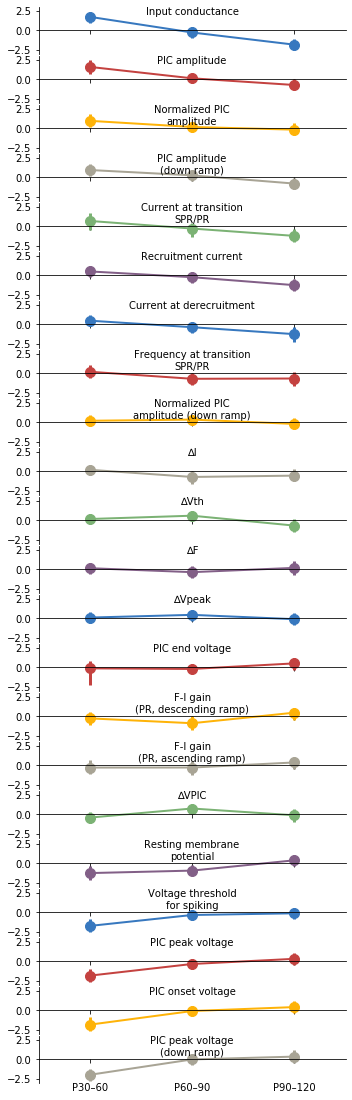

In [62]:
idx = pd.IndexSlice
w = 5
h = 0.7

cycler = itertools.cycle(plt.rcParams['axes.prop_cycle']) # color iterator
    
fig, axs = plt.subplots(effects.index.size,1, 
                        figsize=(w,h*effects.index.size), 
                        sharex=True, sharey=True)

for (prop,row),ax in zip(effects.loc[:,idx['Hedges\' g',:,:]].iterrows(), axs):
    sns.despine(ax=ax)
    c = next(cycler)['color']
    es = row[idx[:,:,'es']].values
    err = np.abs(np.vstack([row[:,:,'lo'].values,row[:,:,'hi'].values])-es)
    ax.errorbar(x=range(len(es)), y=es, yerr=err, fmt='o-', ms=10, lw=2, c=c, elinewidth=3, capsize=0, label=props_labels[prop])
    ax.spines['bottom'].set_position('zero')
    ax.annotate(props_labels[prop], xy=(0.5,1), xycoords='axes fraction', va='top', ha='center')
    
axs[-1].set_xlim(-0.5,2.5)
axs[-1].set_ylim(-3,3)
axs[-1].set_xticks(range(len(ageOrder)))
axs[-1].set_xticklabels([])
for i,age in enumerate(ageOrder):
    axs[-1].annotate(age, xy=(i,0), xycoords=('data','axes fraction'), va='top', ha='center', fontsize=plt.rcParams['xtick.labelsize'])
    

fig.tight_layout()
fig.subplots_adjust(hspace=0.05)

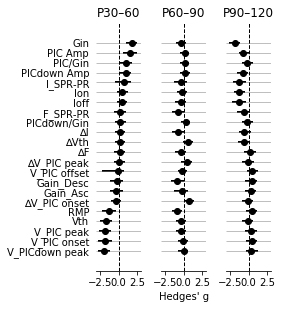

In [19]:
Nprops = effects.index.size
w = 4
h = 0.2
fig, axs = plt.subplots(1,3, sharey=True, figsize=(w,h*Nprops))
for age,ax in zip(ageOrder, axs):
    ax.set_xlim(-3,3)
    x = effects[('Hedges\' g',age,'es')].values
    y = effects[('Hedges\' g',age,'es')].index
    x_low = effects[('Hedges\' g',age,'lo')].values
    x_high = effects[('Hedges\' g',age,'hi')].values
    ax.plot(x,y, 'ko')
    ax.hlines(y, x_low, x_high, lw=2)
    ax.hlines(y,*ax.get_xlim(), lw=0.5, color='grey')
    ax.set_title(age)
    ax.axvline(0,ls='--',c='k', lw=1)
    sns.despine(left=True, right=True, top=True, bottom=False)
    for tick in ax.get_yticklines():
        tick.set_visible(False)

ymin,ymax = ax.get_ylim()
ax.set_ylim(ymin-1, ymax+1)
ax.invert_yaxis()

axs[1].set_xlabel('Hedges\' g')
fig.tight_layout()

In [65]:
N=6

In [66]:
top = effects['Hedges\' g','P30–60','es'].abs().sort_values(ascending=False).head(N).index

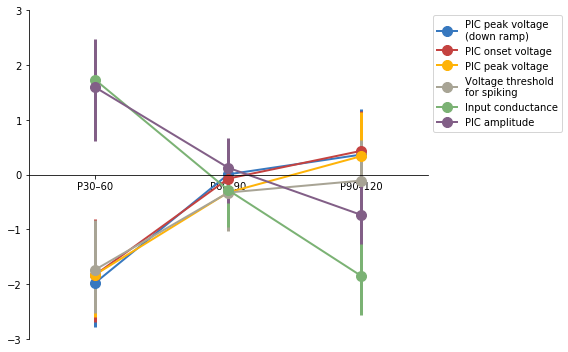

In [71]:
idx = pd.IndexSlice
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylim(-3,3)
ax.set_xlim(-0.5,2.5)
ax.spines['bottom'].set_position('zero')
sns.despine(ax=ax)
for prop,row in effects.loc[top,idx['Hedges\' g',:,:]].iterrows():
    es = row[idx[:,:,'es']].values
    err = np.abs(np.vstack([row[:,:,'lo'].values,row[:,:,'hi'].values])-es)
    ax.errorbar(x=range(len(es)), y=es, yerr=err, fmt='o-', ms=10, lw=2, elinewidth=3, capsize=0, label=props_labels[prop])
ax.legend(loc=2, bbox_to_anchor=(1,1))
ax.set_xticks(range(len(ageOrder)))
ax.set_xticklabels(ageOrder)
fig.tight_layout()

### PIC Amp

In [24]:
prop = 'PIC Amp'
units = props_units[prop]
precision = '.2f'
full = ''
for age in ageOrder:
    out = compare_WT_SOD(data.loc[data['AgeGroup']==age].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 
    display(md(f' - {age}'))
    display(md(out))
    full += age+' '
    full += out
    full += '. '
print('complete output:')
display(md(full))

 - P30–60

WT: 2.30±2.17nA, N=19 vs. SOD1: 6.73±3.28nA, N=15; *g*=1.59 95%CI[0.63–2.45]; *t*(32)=−4.50, *p*=0.00016

 - P60–90

WT: 2.47±1.69nA, N=16 vs. SOD1: 2.75±2.40nA, N=24; *g*=0.12 95%CI[−0.53–0.65]; *t*(38)=−0.42, *p*=0.67

 - P90–120

WT: 4.12±3.69nA, N=15 vs. SOD1: 1.90±1.78nA, N=14; *g*=−0.74 95%CI[−1.26–0.01]; *t*(27)=2.08, *p*=0.05

complete output:


P30–60 WT: 2.30±2.17nA, N=19 vs. SOD1: 6.73±3.28nA, N=15; *g*=1.59 95%CI[0.63–2.45]; *t*(32)=−4.50, *p*=0.00016. P60–90 WT: 2.47±1.69nA, N=16 vs. SOD1: 2.75±2.40nA, N=24; *g*=0.12 95%CI[−0.53–0.65]; *t*(38)=−0.42, *p*=0.67. P90–120 WT: 4.12±3.69nA, N=15 vs. SOD1: 1.90±1.78nA, N=14; *g*=−0.74 95%CI[−1.26–0.01]; *t*(27)=2.08, *p*=0.05. 

/Users/manuel/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


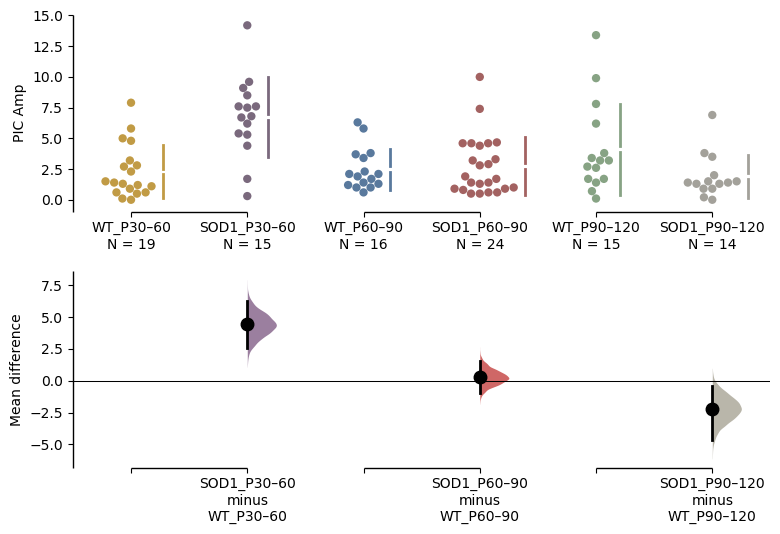

In [25]:
mean_diffs[prop].plot();

#### Regression PIC Amp vs. Age

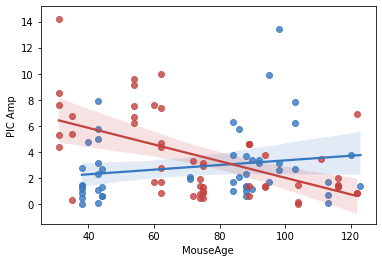

In [26]:
fig, ax = plt.subplots()
sns.regplot(data=data.loc[data['Genotype']=='WT'], x='MouseAge',y='PIC Amp', label='WT')
sns.regplot(data=data.loc[data['Genotype']=='SOD1'], x='MouseAge',y='PIC Amp', label='SOD1')

In [27]:
for gen in genotypeOrder:
    x,y = data.loc[data['Genotype']==gen,['MouseAge','PIC Amp']].dropna().T.values
    s,i,r,p,e = st.linregress(x,y)
    
    #confidence interval
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    alpha = 0.05
    z = st.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    display(md(" - **{:s}:**\n\n *r*={:.2f} 95%CI[{:.2f}&nbsp;–&nbsp;{:.2f}] (*p*={:.2g})\n\n slope = {:.2f} nA/week".format(gen,lo,hi,r,p,s*7).replace('-','−')))

 − **WT:**

 *r*=−0.10 95%CI[0.44&nbsp;–&nbsp;0.18] (*p*=0.2)

 slope = 0.12 nA/week

 − **SOD1:**

 *r*=−0.70 95%CI[−0.31&nbsp;–&nbsp;−0.54] (*p*=3.4e−05)

 slope = −0.45 nA/week

### PIC onset voltage

In [28]:
prop = 'V_PIC onset'
units = props_units[prop]
precision = '.2f'
full = ''
for age in ageOrder:
    out = compare_WT_SOD(data.loc[data['AgeGroup']==age].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 
    display(md(f' - {age}'))
    display(md(out))
    full += age+' '
    full += out
    full += '. '
print('complete output:')
display(md(full))

 - P30–60

WT: −58.03±6.35mV, N=19 vs. SOD1: −69.41±5.71mV, N=15; *g*=−1.83 95%CI[−2.64–−0.78]; *t*(32)=5.49, *p*=5.1e−06

 - P60–90

WT: −59.23±4.88mV, N=16 vs. SOD1: −59.66±6.39mV, N=24; *g*=−0.07 95%CI[−0.70–0.52]; *t*(38)=0.24, *p*=0.81

 - P90–120

WT: −63.15±6.31mV, N=15 vs. SOD1: −60.12±7.25mV, N=14; *g*=0.43 95%CI[−0.33–1.21]; *t*(27)=−1.20, *p*=0.24

complete output:


P30–60 WT: −58.03±6.35mV, N=19 vs. SOD1: −69.41±5.71mV, N=15; *g*=−1.83 95%CI[−2.64–−0.78]; *t*(32)=5.49, *p*=5.1e−06. P60–90 WT: −59.23±4.88mV, N=16 vs. SOD1: −59.66±6.39mV, N=24; *g*=−0.07 95%CI[−0.70–0.52]; *t*(38)=0.24, *p*=0.81. P90–120 WT: −63.15±6.31mV, N=15 vs. SOD1: −60.12±7.25mV, N=14; *g*=0.43 95%CI[−0.33–1.21]; *t*(27)=−1.20, *p*=0.24. 

### PIC peak voltage

In [29]:
prop = 'V_PIC peak'
units = props_units[prop]
precision = '.2f'
full = ''
for age in ageOrder:
    out = compare_WT_SOD(data.loc[data['AgeGroup']==age].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 
    display(md(f' - {age}'))
    display(md(out))
    full += age+' '
    full += out
    full += '. '
print('complete output:')
display(md(full))

 - P30–60

WT: −43.83±4.79mV, N=19 vs. SOD1: −52.32±4.20mV, N=15; *g*=−1.83 95%CI[−2.63–−1.04]; *t*(32)=5.50, *p*=4.8e−06

 - P60–90

WT: −42.89±6.94mV, N=16 vs. SOD1: −44.88±5.24mV, N=24; *g*=−0.33 95%CI[−0.99–0.33]; *t*(38)=0.97, *p*=0.34

 - P90–120

WT: −48.34±5.89mV, N=15 vs. SOD1: −46.24±6.27mV, N=14; *g*=0.34 95%CI[−0.42–1.14]; *t*(27)=−0.93, *p*=0.36

complete output:


P30–60 WT: −43.83±4.79mV, N=19 vs. SOD1: −52.32±4.20mV, N=15; *g*=−1.83 95%CI[−2.63–−1.04]; *t*(32)=5.50, *p*=4.8e−06. P60–90 WT: −42.89±6.94mV, N=16 vs. SOD1: −44.88±5.24mV, N=24; *g*=−0.33 95%CI[−0.99–0.33]; *t*(38)=0.97, *p*=0.34. P90–120 WT: −48.34±5.89mV, N=15 vs. SOD1: −46.24±6.27mV, N=14; *g*=0.34 95%CI[−0.42–1.14]; *t*(27)=−0.93, *p*=0.36. 

### Vth

In [30]:
prop = 'Vth'
units = props_units[prop]
precision = '.2f'
full = ''
for age in ageOrder:
    out = compare_WT_SOD(data.loc[data['AgeGroup']==age].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 
    display(md(f' - {age}'))
    display(md(out))
    full += age+' '
    full += out
    full += '. '
print('complete output:')
display(md(full))

 - P30–60

WT: −45.35±5.48mV, N=19 vs. SOD1: −54.86±5.15mV, N=14; *g*=−1.74 95%CI[−2.53–−0.81]; *t*(31)=5.10, *p*=1.9e−05

 - P60–90

WT: −45.39±7.04mV, N=16 vs. SOD1: −47.53±5.85mV, N=20; *g*=−0.33 95%CI[−1.01–0.41]; *t*(34)=0.98, *p*=0.34

 - P90–120

WT: −47.61±5.00mV, N=15 vs. SOD1: −48.20±5.41mV, N=13; *g*=−0.11 95%CI[−0.89–0.66]; *t*(26)=0.30, *p*=0.77

complete output:


P30–60 WT: −45.35±5.48mV, N=19 vs. SOD1: −54.86±5.15mV, N=14; *g*=−1.74 95%CI[−2.53–−0.81]; *t*(31)=5.10, *p*=1.9e−05. P60–90 WT: −45.39±7.04mV, N=16 vs. SOD1: −47.53±5.85mV, N=20; *g*=−0.33 95%CI[−1.01–0.41]; *t*(34)=0.98, *p*=0.34. P90–120 WT: −47.61±5.00mV, N=15 vs. SOD1: −48.20±5.41mV, N=13; *g*=−0.11 95%CI[−0.89–0.66]; *t*(26)=0.30, *p*=0.77. 

### Recruitment current

In [31]:
prop = 'Ion'
units = props_units[prop]
precision = '.2f'
full = ''
for age in ageOrder:
    out = compare_WT_SOD(data.loc[data['AgeGroup']==age].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 
    display(md(f' - {age}'))
    display(md(out))
    full += age+' '
    full += out
    full += '. '
print('complete output:')
display(md(full))

 - P30–60

WT: 4.73±3.14nA, N=19 vs. SOD1: 6.21±2.51nA, N=14; *g*=0.50 95%CI[−0.24–1.24]; *t*(31)=−1.51, *p*=0.14

 - P60–90

WT: 5.28±2.64nA, N=16 vs. SOD1: 4.53±3.38nA, N=20; *g*=−0.24 95%CI[−0.93–0.41]; *t*(34)=0.75, *p*=0.46

 - P90–120

WT: 5.43±3.07nA, N=15 vs. SOD1: 2.19±1.56nA, N=13; *g*=−1.26 95%CI[−1.95–−0.47]; *t*(26)=3.59, *p*=0.0017

complete output:


P30–60 WT: 4.73±3.14nA, N=19 vs. SOD1: 6.21±2.51nA, N=14; *g*=0.50 95%CI[−0.24–1.24]; *t*(31)=−1.51, *p*=0.14. P60–90 WT: 5.28±2.64nA, N=16 vs. SOD1: 4.53±3.38nA, N=20; *g*=−0.24 95%CI[−0.93–0.41]; *t*(34)=0.75, *p*=0.46. P90–120 WT: 5.43±3.07nA, N=15 vs. SOD1: 2.19±1.56nA, N=13; *g*=−1.26 95%CI[−1.95–−0.47]; *t*(26)=3.59, *p*=0.0017. 

/Users/manuel/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


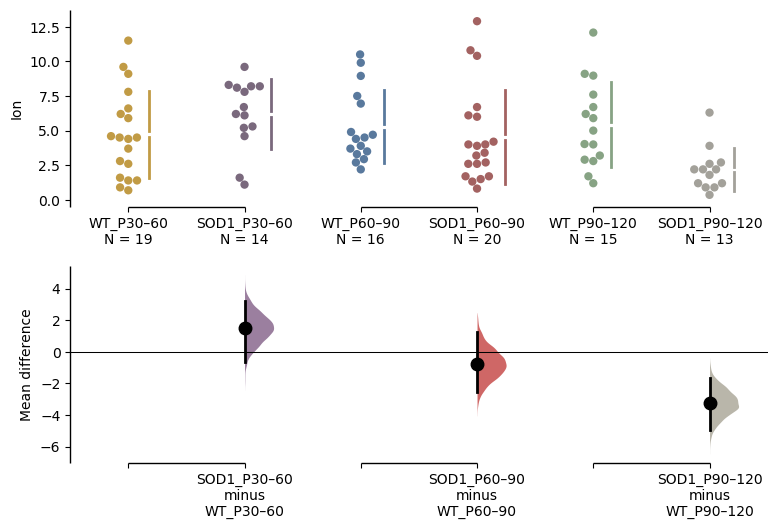

In [32]:
mean_diffs[prop].plot();

### F-I gain

In [33]:
prop = 'Gain_Asc'
units = props_units[prop]
precision = '.1f'
full = ''
for age in ageOrder:
    out = compare_WT_SOD(data.loc[data['AgeGroup']==age].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 
    display(md(f' - {age}'))
    display(md(out))
    full += age+' '
    full += out
    full += '. '
print('complete output:')
display(md(full))

 - P30–60

WT: 9.3±3.6Hz/nA, N=10 vs. SOD1: 8.3±3.4Hz/nA, N=14; *g*=−0.28 95%CI[−1.10–0.64]; *t*(22)=0.69, *p*=0.5

 - P60–90

WT: 12.2±7.3Hz/nA, N=8 vs. SOD1: 10.3±6.4Hz/nA, N=16; *g*=−0.27 95%CI[−1.22–0.54]; *t*(22)=0.62, *p*=0.54

 - P90–120

WT: 8.0±3.2Hz/nA, N=10 vs. SOD1: 10.8±9.1Hz/nA, N=13; *g*=0.38 95%CI[−0.43–0.93]; *t*(21)=−1.04, *p*=0.31

complete output:


P30–60 WT: 9.3±3.6Hz/nA, N=10 vs. SOD1: 8.3±3.4Hz/nA, N=14; *g*=−0.28 95%CI[−1.10–0.64]; *t*(22)=0.69, *p*=0.5. P60–90 WT: 12.2±7.3Hz/nA, N=8 vs. SOD1: 10.3±6.4Hz/nA, N=16; *g*=−0.27 95%CI[−1.22–0.54]; *t*(22)=0.62, *p*=0.54. P90–120 WT: 8.0±3.2Hz/nA, N=10 vs. SOD1: 10.8±9.1Hz/nA, N=13; *g*=0.38 95%CI[−0.43–0.93]; *t*(21)=−1.04, *p*=0.31. 

### Input conductance

In [34]:
prop = 'Gin'
units = props_units[prop]
precision = '.2f'
full = ''
for age in ageOrder:
    out = compare_WT_SOD(data.loc[data['AgeGroup']==age].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 
    display(md(f' - {age}'))
    display(md(out))
    full += age+' '
    full += out
    full += '. '
print('complete output:')
display(md(full))

 - P30–60

WT: 0.42±0.16μS, N=19 vs. SOD1: 0.72±0.18μS, N=15; *g*=1.73 95%CI[0.92–2.41]; *t*(32)=−5.06, *p*=2.2e−05

 - P60–90

WT: 0.46±0.16μS, N=16 vs. SOD1: 0.42±0.15μS, N=24; *g*=−0.28 95%CI[−0.96–0.37]; *t*(38)=0.88, *p*=0.39

 - P90–120

WT: 0.60±0.15μS, N=15 vs. SOD1: 0.33±0.13μS, N=14; *g*=−1.85 95%CI[−2.57–−1.16]; *t*(27)=5.16, *p*=2.1e−05

complete output:


P30–60 WT: 0.42±0.16μS, N=19 vs. SOD1: 0.72±0.18μS, N=15; *g*=1.73 95%CI[0.92–2.41]; *t*(32)=−5.06, *p*=2.2e−05. P60–90 WT: 0.46±0.16μS, N=16 vs. SOD1: 0.42±0.15μS, N=24; *g*=−0.28 95%CI[−0.96–0.37]; *t*(38)=0.88, *p*=0.39. P90–120 WT: 0.60±0.15μS, N=15 vs. SOD1: 0.33±0.13μS, N=14; *g*=−1.85 95%CI[−2.57–−1.16]; *t*(27)=5.16, *p*=2.1e−05. 

/Users/manuel/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


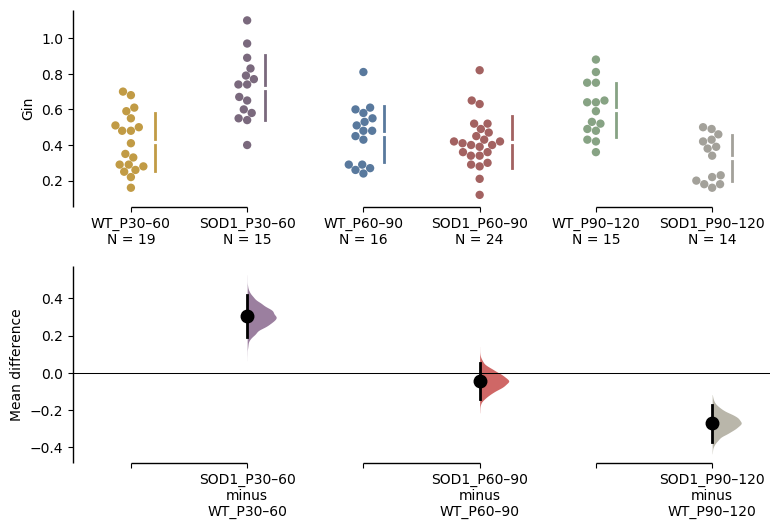

In [35]:
mean_diffs[prop].plot();

#### Regression Gin vs. Age

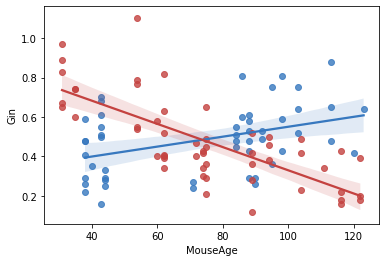

In [36]:
fig, ax = plt.subplots()
sns.regplot(data=data.loc[data['Genotype']=='WT'], x='MouseAge',y='Gin', label='WT')
sns.regplot(data=data.loc[data['Genotype']=='SOD1'], x='MouseAge',y='Gin', label='SOD1')

In [37]:
for gen in genotypeOrder:
    x,y = data.loc[data['Genotype']==gen,['MouseAge','Gin']].dropna().T.values
    s,i,r,p,e = st.linregress(x,y)
    
    #confidence interval
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    alpha = 0.05
    z = st.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    display(md(" - **{:s}:**\n\n *r*={:.2f} 95%CI[{:.2f}&nbsp;–&nbsp;{:.2f}] (*p*={:.2g})\n\n slope = {:.2f} nA/week".format(gen,lo,hi,r,p,s*7).replace('-','−')))

 − **WT:**

 *r*=0.14 95%CI[0.61&nbsp;–&nbsp;0.40] (*p*=0.0035)

 slope = 0.02 nA/week

 − **SOD1:**

 *r*=−0.83 95%CI[−0.57&nbsp;–&nbsp;−0.73] (*p*=6.1e−10)

 slope = −0.04 nA/week

### RMP

In [38]:
prop = 'RMP'
units = props_units[prop]
precision = '.2f'
full = ''
for age in ageOrder:
    out = compare_WT_SOD(data.loc[data['AgeGroup']==age].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 
    display(md(f' - {age}'))
    display(md(out))
    full += age+' '
    full += out
    full += '. '
print('complete output:')
display(md(full))

 - P30–60

WT: −62.38±5.52mV, N=19 vs. SOD1: −71.45±8.78mV, N=15; *g*=−1.24 95%CI[−2.13–−0.23]; *t*(32)=3.49, *p*=0.002

 - P60–90

WT: −60.98±5.35mV, N=16 vs. SOD1: −66.18±5.63mV, N=22; *g*=−0.92 95%CI[−1.54–−0.18]; *t*(36)=2.89, *p*=0.0067

 - P90–120

WT: −64.71±7.42mV, N=15 vs. SOD1: −61.99±5.43mV, N=13; *g*=0.40 95%CI[−0.35–1.10]; *t*(26)=−1.12, *p*=0.27

complete output:


P30–60 WT: −62.38±5.52mV, N=19 vs. SOD1: −71.45±8.78mV, N=15; *g*=−1.24 95%CI[−2.13–−0.23]; *t*(32)=3.49, *p*=0.002. P60–90 WT: −60.98±5.35mV, N=16 vs. SOD1: −66.18±5.63mV, N=22; *g*=−0.92 95%CI[−1.54–−0.18]; *t*(36)=2.89, *p*=0.0067. P90–120 WT: −64.71±7.42mV, N=15 vs. SOD1: −61.99±5.43mV, N=13; *g*=0.40 95%CI[−0.35–1.10]; *t*(26)=−1.12, *p*=0.27. 

/Users/manuel/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


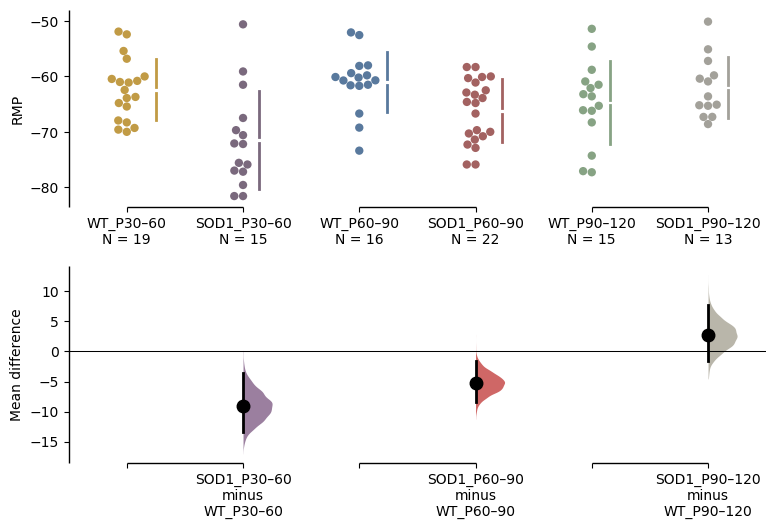

In [39]:
mean_diffs[prop].plot();

### Normalized PIC Amp

In [40]:
prop = 'PIC/Gin'
units = props_units[prop]
precision = '.2f'
full = ''
for age in ageOrder:
    out = compare_WT_SOD(data.loc[data['AgeGroup']==age].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 
    display(md(f' - {age}'))
    display(md(out))
    full += age+' '
    full += out
    full += '. '
print('complete output:')
display(md(full))

 - P30–60

WT: 5.35±4.11nA/μS, N=19 vs. SOD1: 9.32±3.94nA/μS, N=15; *g*=0.96 95%CI[0.16–1.76]; *t*(32)=−2.86, *p*=0.0075

 - P60–90

WT: 5.65±3.35nA/μS, N=16 vs. SOD1: 6.46±5.39nA/μS, N=24; *g*=0.17 95%CI[−0.50–0.66]; *t*(38)=−0.59, *p*=0.56

 - P90–120

WT: 6.80±5.01nA/μS, N=15 vs. SOD1: 5.93±4.53nA/μS, N=14; *g*=−0.18 95%CI[−0.88–0.63]; *t*(27)=0.49, *p*=0.63

complete output:


P30–60 WT: 5.35±4.11nA/μS, N=19 vs. SOD1: 9.32±3.94nA/μS, N=15; *g*=0.96 95%CI[0.16–1.76]; *t*(32)=−2.86, *p*=0.0075. P60–90 WT: 5.65±3.35nA/μS, N=16 vs. SOD1: 6.46±5.39nA/μS, N=24; *g*=0.17 95%CI[−0.50–0.66]; *t*(38)=−0.59, *p*=0.56. P90–120 WT: 6.80±5.01nA/μS, N=15 vs. SOD1: 5.93±4.53nA/μS, N=14; *g*=−0.18 95%CI[−0.88–0.63]; *t*(27)=0.49, *p*=0.63. 

/Users/manuel/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


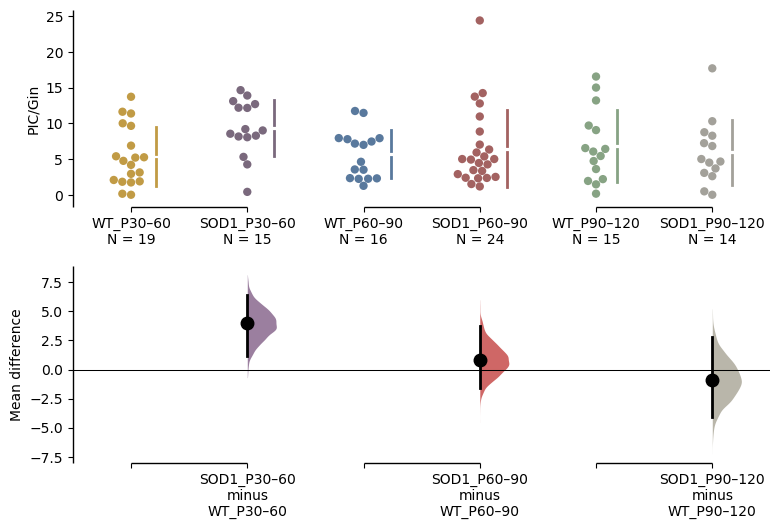

In [41]:
mean_diffs[prop].plot();

## Firing vs. Non-Firing

### Input conductance

In [42]:
prop = 'Gin'
units = props_units[prop]
precision = '.2f'
full = ''

out = compare_WT_SOD(data.loc[data['Genotype']=='SOD1'].pivot(columns='RepFiring',values=prop).reindex(['Firing','Non-firing'], axis=1), units, precision) 

display(md(out))

Firing: 0.49±0.22μS, N=47 vs. Non−firing: 0.38±0.20μS, N=6; *g*=−0.54 95%CI[−1.11–0.50]; *t*(51)=1.36, *p*=0.22

### PIC Amp

In [43]:
prop = 'PIC Amp'
units = props_units[prop]
precision = '.2f'
full = ''

out = compare_WT_SOD(data.loc[data['Genotype']=='SOD1'].pivot(columns='RepFiring',values=prop).reindex(['Firing','Non-firing'], axis=1), units, precision) 

display(md(out))

Firing: 4.04±3.18nA, N=47 vs. Non−firing: 0.60±0.49nA, N=6; *g*=−1.12 95%CI[−1.42–−0.86]; *t*(51)=6.81, *p*=1.3e−08

### Normalized PIC Amp

In [44]:
prop = 'PIC/Gin'
units = props_units[prop]
precision = '.2f'
full = ''

out = compare_WT_SOD(data.loc[data['Genotype']=='SOD1'].pivot(columns='RepFiring',values=prop).reindex(['Firing','Non-firing'], axis=1), units, precision) 

display(md(out))

Firing: 7.80±4.79nA/μS, N=47 vs. Non−firing: 1.91±1.82nA/μS, N=6; *g*=−1.27 95%CI[−1.65–−0.80]; *t*(51)=5.77, *p*=2.6e−05

### Age

In [45]:
prop = 'MouseAge'
units = 'days'
precision = '.0f'
full = ''

out = compare_WT_SOD(data.loc[data['RepFiring']=='Non-firing'].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 

display(md(out))

WT: 100±16days, N=7 vs. SOD1: 75±23days, N=6; *g*=−1.20 95%CI[−2.06–0.01]; *t*(11)=2.24, *p*=0.053

limit to the top {{N}} effect sizes at P30–60

# Figure 1

In [46]:
wtVCRamp = pd.read_csv('./Cell324_003_exampleVCRamp.txt')
wtVCRamp_example = 324
sodVCRamp = pd.read_csv('./Cell743_003_exampleVCRamp.txt')
sodVCRamp_example = 743

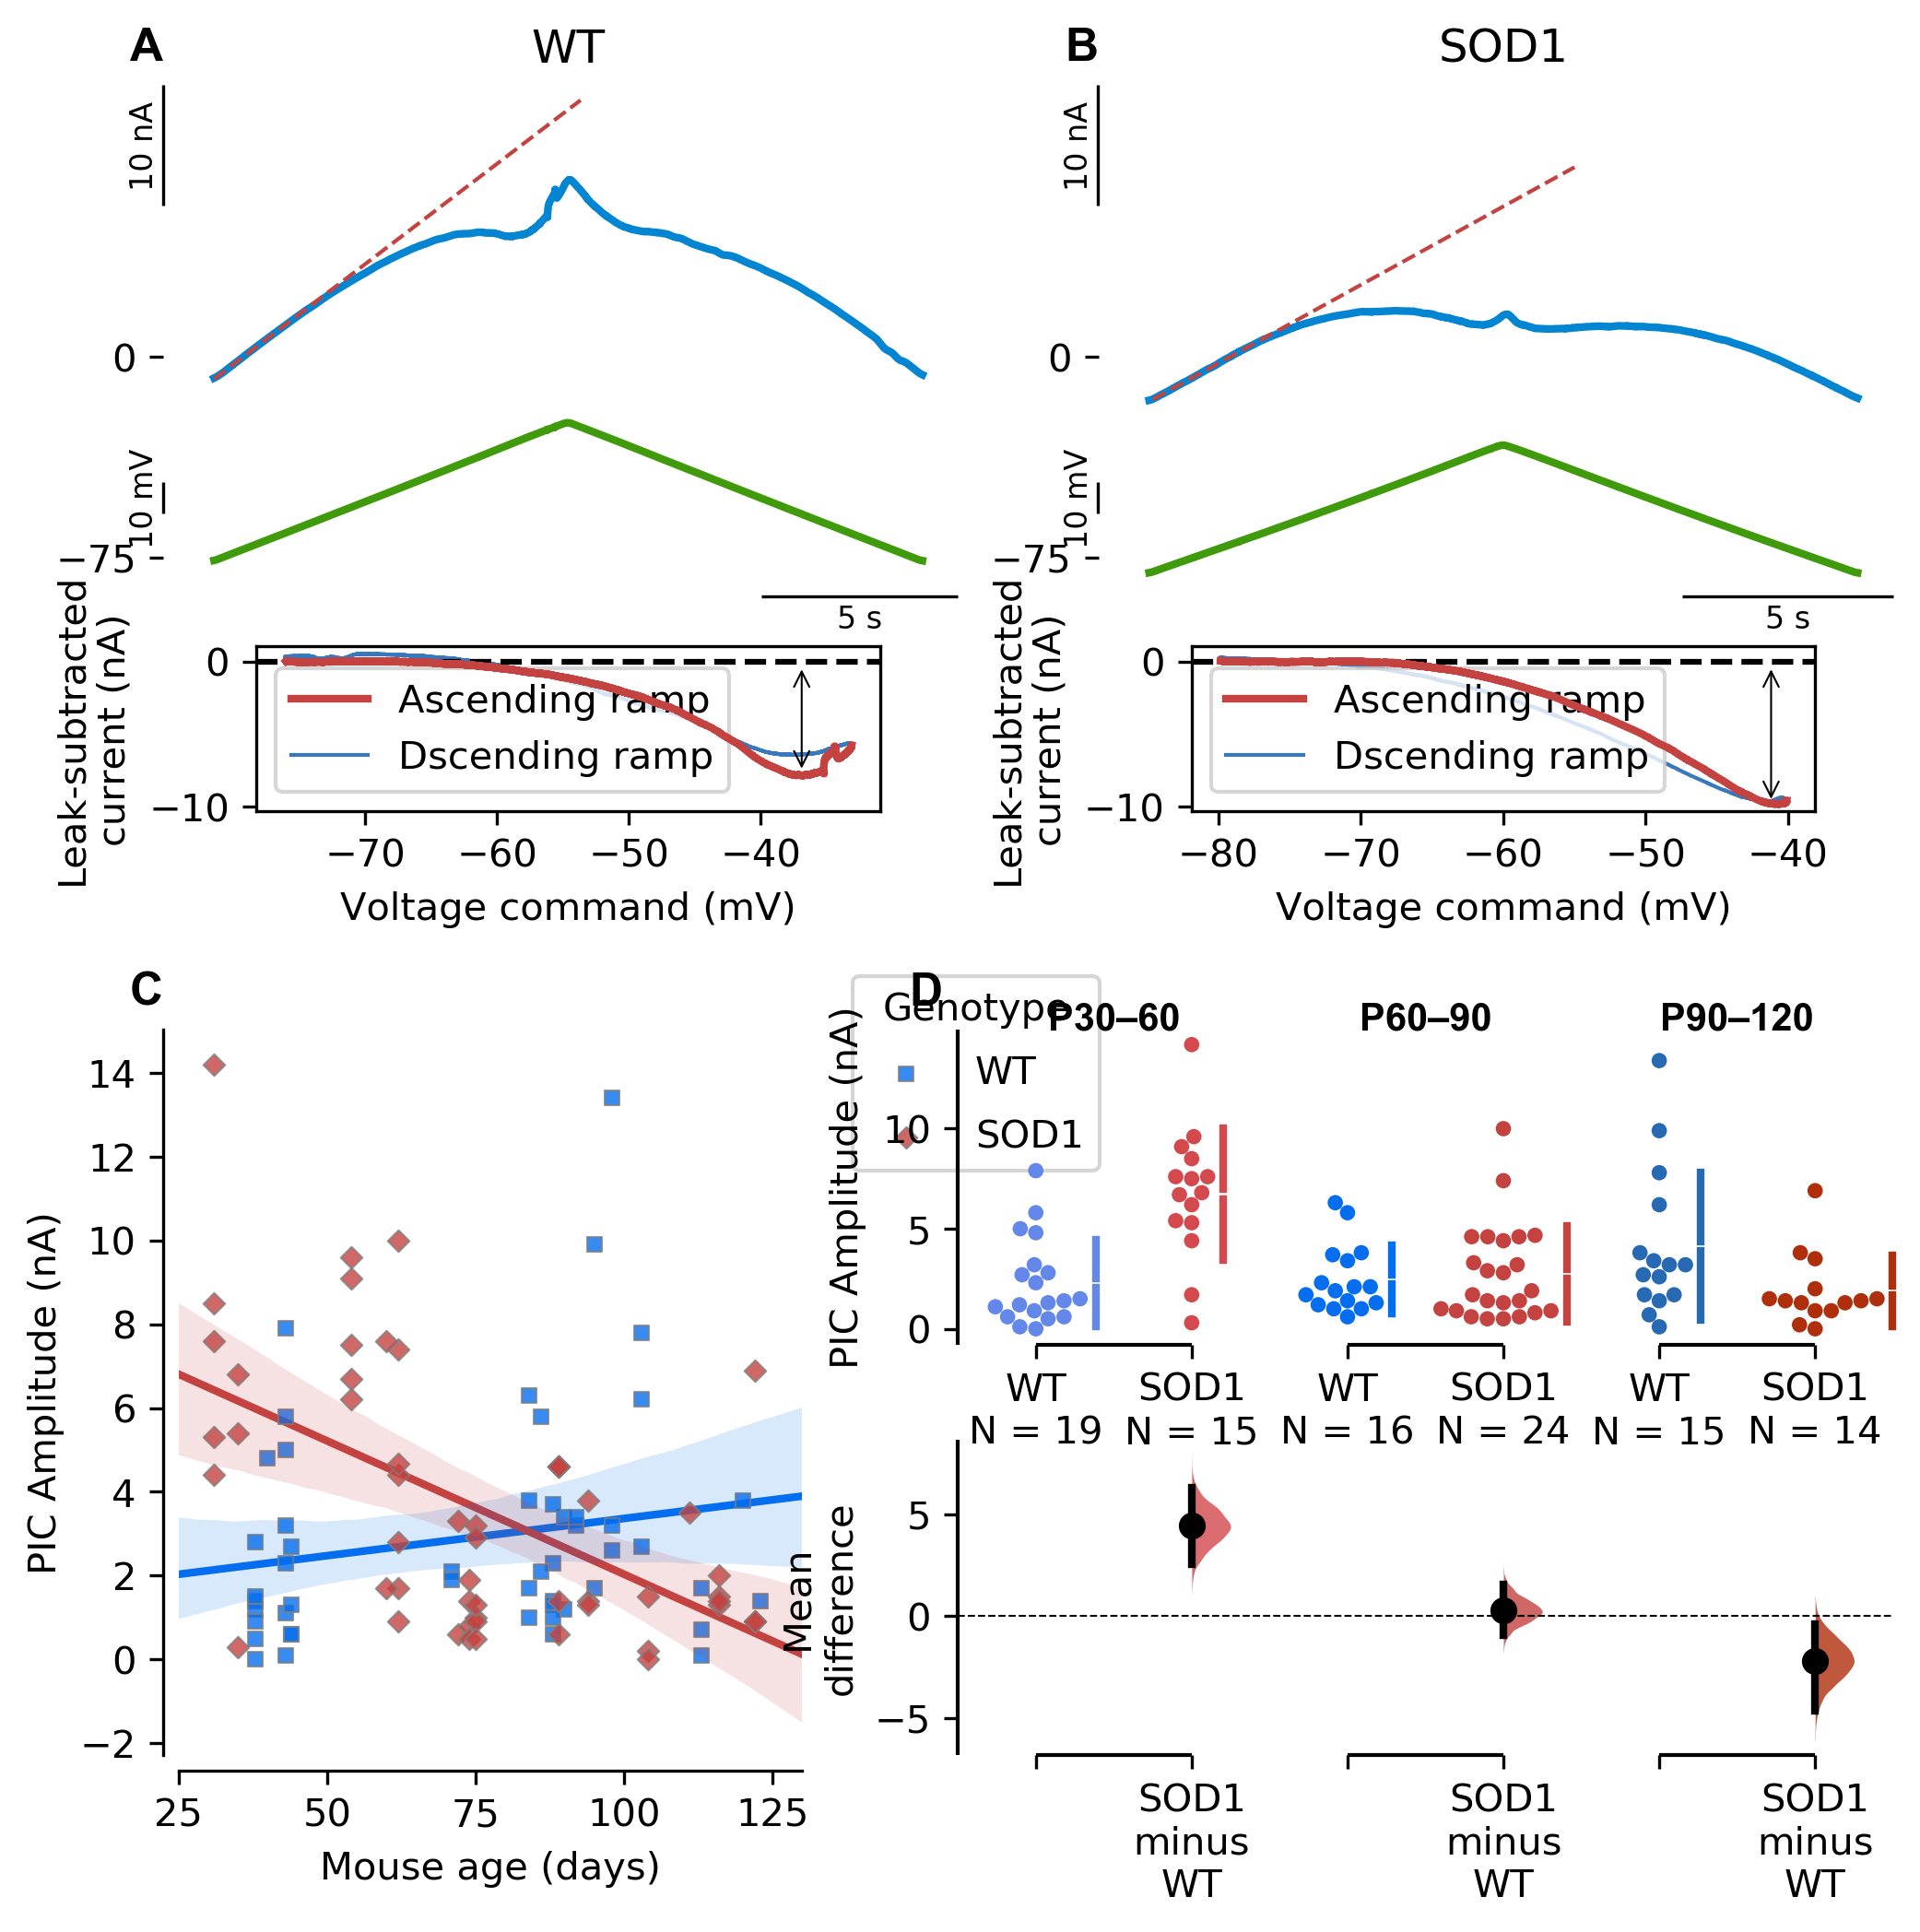

In [47]:
fig = plt.figure(figsize=(8,8), dpi=300)
out_gs = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[3,3], hspace=0.3)
top_gs = gridspec.GridSpecFromSubplotSpec(2,2,subplot_spec=out_gs[0], height_ratios=[3,1], hspace=0.2)
AB_gs = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=top_gs[0,:], height_ratios=[2,1], hspace=0)
bottom_gs = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=out_gs[-1], width_ratios=[2,3])

ax00 = fig.add_subplot(AB_gs[0,0])
ax10 = fig.add_subplot(AB_gs[1,0])
ax20 = fig.add_subplot(top_gs[1,0])
ax01 = fig.add_subplot(AB_gs[0,1], sharey=ax00)
ax11 = fig.add_subplot(AB_gs[1,1], sharey=ax10)
ax21 = fig.add_subplot(top_gs[1,1], sharey=ax20)
ax3 = fig.add_subplot(bottom_gs[0])    
ax4 = fig.add_subplot(bottom_gs[1])

#fig.set_facecolor('grey')
#fig.subplots_adjust(top=0.95, bottom=0.08, left=0.08, right=0.99)

#
# WT VCRamp example
#
ax00.set_title("WT")
ax00.annotate('A', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')
ax00.plot(wtVCRamp['Time'],wtVCRamp['Im'], c=Im_color, lw=2, clip_on=False)
ax00.plot(wtVCRamp['Time'],wtVCRamp['GinFit'], c='xkcd:reddish', ls='--', lw=1)
sns.despine(ax=ax00, bottom=True, top=True, right=True, left=False, offset=4)
ax00.spines['left'].set_visible(False)
ax00.set_yticks([0])
ax00.set_xticks([])
vbar = VSizeBar(ax00.transData,
                10,
                "10 nA",
                loc='upper right',
                pad=0, borderpad=0, sep=1,
                frameon=False,
                bbox_to_anchor=(-0.02, 1.),
                bbox_transform=ax00.transAxes,textprops=dict(fontsize=8))
ax00.add_artist(vbar)


ax10.plot(wtVCRamp['Time'],wtVCRamp['Vm'], c=Vm_color, lw=2, clip_on=False)
sns.despine(ax=ax10, bottom=True, top=True, right=True, left=False, offset=4)
ax10.spines['left'].set_visible(False)
ax10.set_yticks([-75])
ax10.set_xticks([])
vbar = VSizeBar(ax10.transData,
                10,
                "10 mV",
                loc='center right',
                pad=0, borderpad=0, sep=1,
                frameon=False,
                bbox_to_anchor=(-0.02, 0.5),
                bbox_transform=ax10.transAxes,textprops=dict(fontsize=8))
ax10.add_artist(vbar)
tbar1 = HSizeBar(ax10.transData,
                 5,
                 '5 s',
                 loc='upper right',
                 pad=0, borderpad=0, sep=2,
                 frameon=False,
                 bbox_to_anchor=(1, -0.1),
                 bbox_transform=ax10.transAxes,textprops=dict(fontsize=8))
ax10.add_artist(tbar1)



L = wtVCRamp['Vm'].size
ax20.plot(wtVCRamp.loc[:int(L/2),'Vm'],(wtVCRamp['Im']-wtVCRamp['LeakCurrent']).loc[:int(L/2)], c='xkcd:reddish', lw=2, label='Ascending ramp', zorder=10, clip_on=False)
ax20.plot(wtVCRamp.loc[int(L/2):,'Vm'],(wtVCRamp['Im']-wtVCRamp['LeakCurrent']).loc[int(L/2):], c='xkcd:windows blue', lw=1, label='Dscending ramp', clip_on=False)
ax20.legend(loc='lower left')
ax20.set_xlabel('Voltage command (mV)')
ax20.set_ylabel('Leak-subtracted\ncurrent (nA)')
ax20.axhline(0, ls='--', color='k')
ax20.annotate('',xy=(data.loc[wtVCRamp_example, 'V_PIC peak'], 0), xycoords='data',
                 xytext=(data.loc[wtVCRamp_example, 'V_PIC peak'], -1*data.loc[wtVCRamp_example, 'PIC Amp']), textcoords='data',
              arrowprops=dict(arrowstyle='<->', ls='-', color='k', lw=0.5))
# shring IV plot by 20%
geom = ax20.get_position()
new_width = geom.width*0.8
ax20.set_position([geom.x0+(geom.width-new_width)/2, geom.y0, new_width, geom.height])


#
# SOD1 VCRamp example
#
ax01.set_title("SOD1")
ax01.annotate('B', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')
ax01.plot(sodVCRamp['Time'],sodVCRamp['Im'], c=Im_color, lw=2, clip_on=False)
ax01.plot(sodVCRamp['Time'],sodVCRamp['GinFit'], c='xkcd:reddish', ls='--', lw=1)
sns.despine(ax=ax01, bottom=True, top=True, right=True, left=False, offset=4)
ax01.spines['left'].set_visible(False)
ax01.set_yticks([0])
ax01.set_xticks([])
vbar = VSizeBar(ax01.transData,
                10,
                "10 nA",
                loc='upper right',
                pad=0, borderpad=0, sep=1,
                frameon=False,
                bbox_to_anchor=(-0.02, 1.),
                bbox_transform=ax01.transAxes,textprops=dict(fontsize=8))
ax01.add_artist(vbar)


ax11.plot(sodVCRamp['Time'],sodVCRamp['Vm'], c=Vm_color, lw=2, clip_on=False)
sns.despine(ax=ax11, bottom=True, top=True, right=True, left=False, offset=4)
ax11.spines['left'].set_visible(False)
ax11.set_yticks([-75])
ax11.set_xticks([])
vbar = VSizeBar(ax11.transData,
                10,
                "10 mV",
                loc='center right',
                pad=0, borderpad=0, sep=1,
                frameon=False,
                bbox_to_anchor=(-0.02, 0.5),
                bbox_transform=ax11.transAxes,textprops=dict(fontsize=8))
ax11.add_artist(vbar)
tbar1 = HSizeBar(ax11.transData,
                 5,
                 '5 s',
                 loc='upper right',
                 pad=0, borderpad=0, sep=2,
                 frameon=False,
                 bbox_to_anchor=(1, -0.1),
                 bbox_transform=ax11.transAxes,textprops=dict(fontsize=8))
ax11.add_artist(tbar1)



L = sodVCRamp['Vm'].size
ax21.plot(sodVCRamp.loc[:int(L/2),'Vm'],(sodVCRamp['Im']-sodVCRamp['LeakCurrent']).loc[:int(L/2)], c='xkcd:reddish', lw=2, label='Ascending ramp', zorder=10, clip_on=False)
ax21.plot(sodVCRamp.loc[int(L/2):,'Vm'],(sodVCRamp['Im']-sodVCRamp['LeakCurrent']).loc[int(L/2):], c='xkcd:windows blue', lw=1, label='Dscending ramp', clip_on=False)
ax21.legend(loc='lower left')
ax21.set_xlabel('Voltage command (mV)')
ax21.set_ylabel('Leak-subtracted\ncurrent (nA)')
ax21.axhline(0, ls='--', color='k')
ax21.annotate('',xy=(data.loc[sodVCRamp_example, 'V_PIC peak'], 0), xycoords='data',
                 xytext=(data.loc[sodVCRamp_example, 'V_PIC peak'], -1*data.loc[sodVCRamp_example, 'PIC Amp']), textcoords='data',
              arrowprops=dict(arrowstyle='<->', ls='-', color='k', lw=0.5))
# shring IV plot by 20%
geom = ax21.get_position()
new_width = geom.width*0.8
ax21.set_position([geom.x0+(geom.width-new_width)/2, geom.y0, new_width, geom.height])


#
# PIC Amp vs. age
#

ax3.set_xlim(25,130)
for g,c,m in zip(genotypeOrder,[my_palette['WT_P60–90'], my_palette['SOD1_P60–90']],['s','D']):
    d = data[(data['Genotype']==g)]
    sns.regplot(data=d, x='MouseAge', y='PIC Amp', ax=ax3, color=c, marker=m,
                scatter=True, scatter_kws=dict(s=4**2, edgecolor='gray', linewidth=0.5, clip_on=False),
                fit_reg=True, label=g, line_kws={'lw':2, 'zorder':-1}, truncate=False)
ax3.legend(title='Genotype', labelspacing=0.7, bbox_to_anchor=(1.05,1.1))
sns.despine(ax=ax3, offset=4)
ax3.set_xlabel("Mouse age (days)")
ax3.set_ylabel('PIC Amplitude (nA)')
ax3.annotate('C', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')

#
# Cummings plot
#

fig = mean_diffs['PIC Amp'].plot(ax=ax4, 
                         swarm_label='PIC Amplitude (nA)', 
                         contrast_label='Mean\ndifference',
                         custom_palette=my_palette,
                         raw_marker_size=4,
                         es_marker_size=6,
                         swarm_desat=1,
                         group_summaries='mean_sd',
                         reflines_kwargs=dict(linestyle='--', linewidth=0.5), swarmplot_kwargs=dict(clip_on=False)
                        );
ax4.set_xticklabels([
    '\n'.join([
        label,tick.get_text().split('\n')[-1]]) for tick,label in zip(ax4.get_xticklabels(), 
                                                                      itertools.cycle(genotypeOrder))])
for (i,label),(tickL,tickR) in zip(enumerate(ageOrder), grouper(ax4.get_xticks(), 2)):
    ax4.annotate(label, xy=(tickL+(tickR-tickL)/2,1), xycoords=('data','axes fraction'), 
                 fontfamily='Arial', ha='center', fontsize=10, fontweight='bold')
ax4.contrast_axes.set_xticklabels(['\nminus\n'.join(genotypeOrder[::-1]) if i%2 else '' for i,label in enumerate(ax4.contrast_axes.get_xticklabels())])
ax4.annotate('D', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')

plt.show()

In [48]:
data.loc[sodVCRamp_example,'MouseAge']

62

# Figure 2

In [49]:
wtCCRamp = pd.read_csv('./Cell1101_001_figureCCRamp.txt')
sodCCRamp = pd.read_csv('./Cell991_001_figureCCRamp.txt')

Text(-4, 4, 'D')

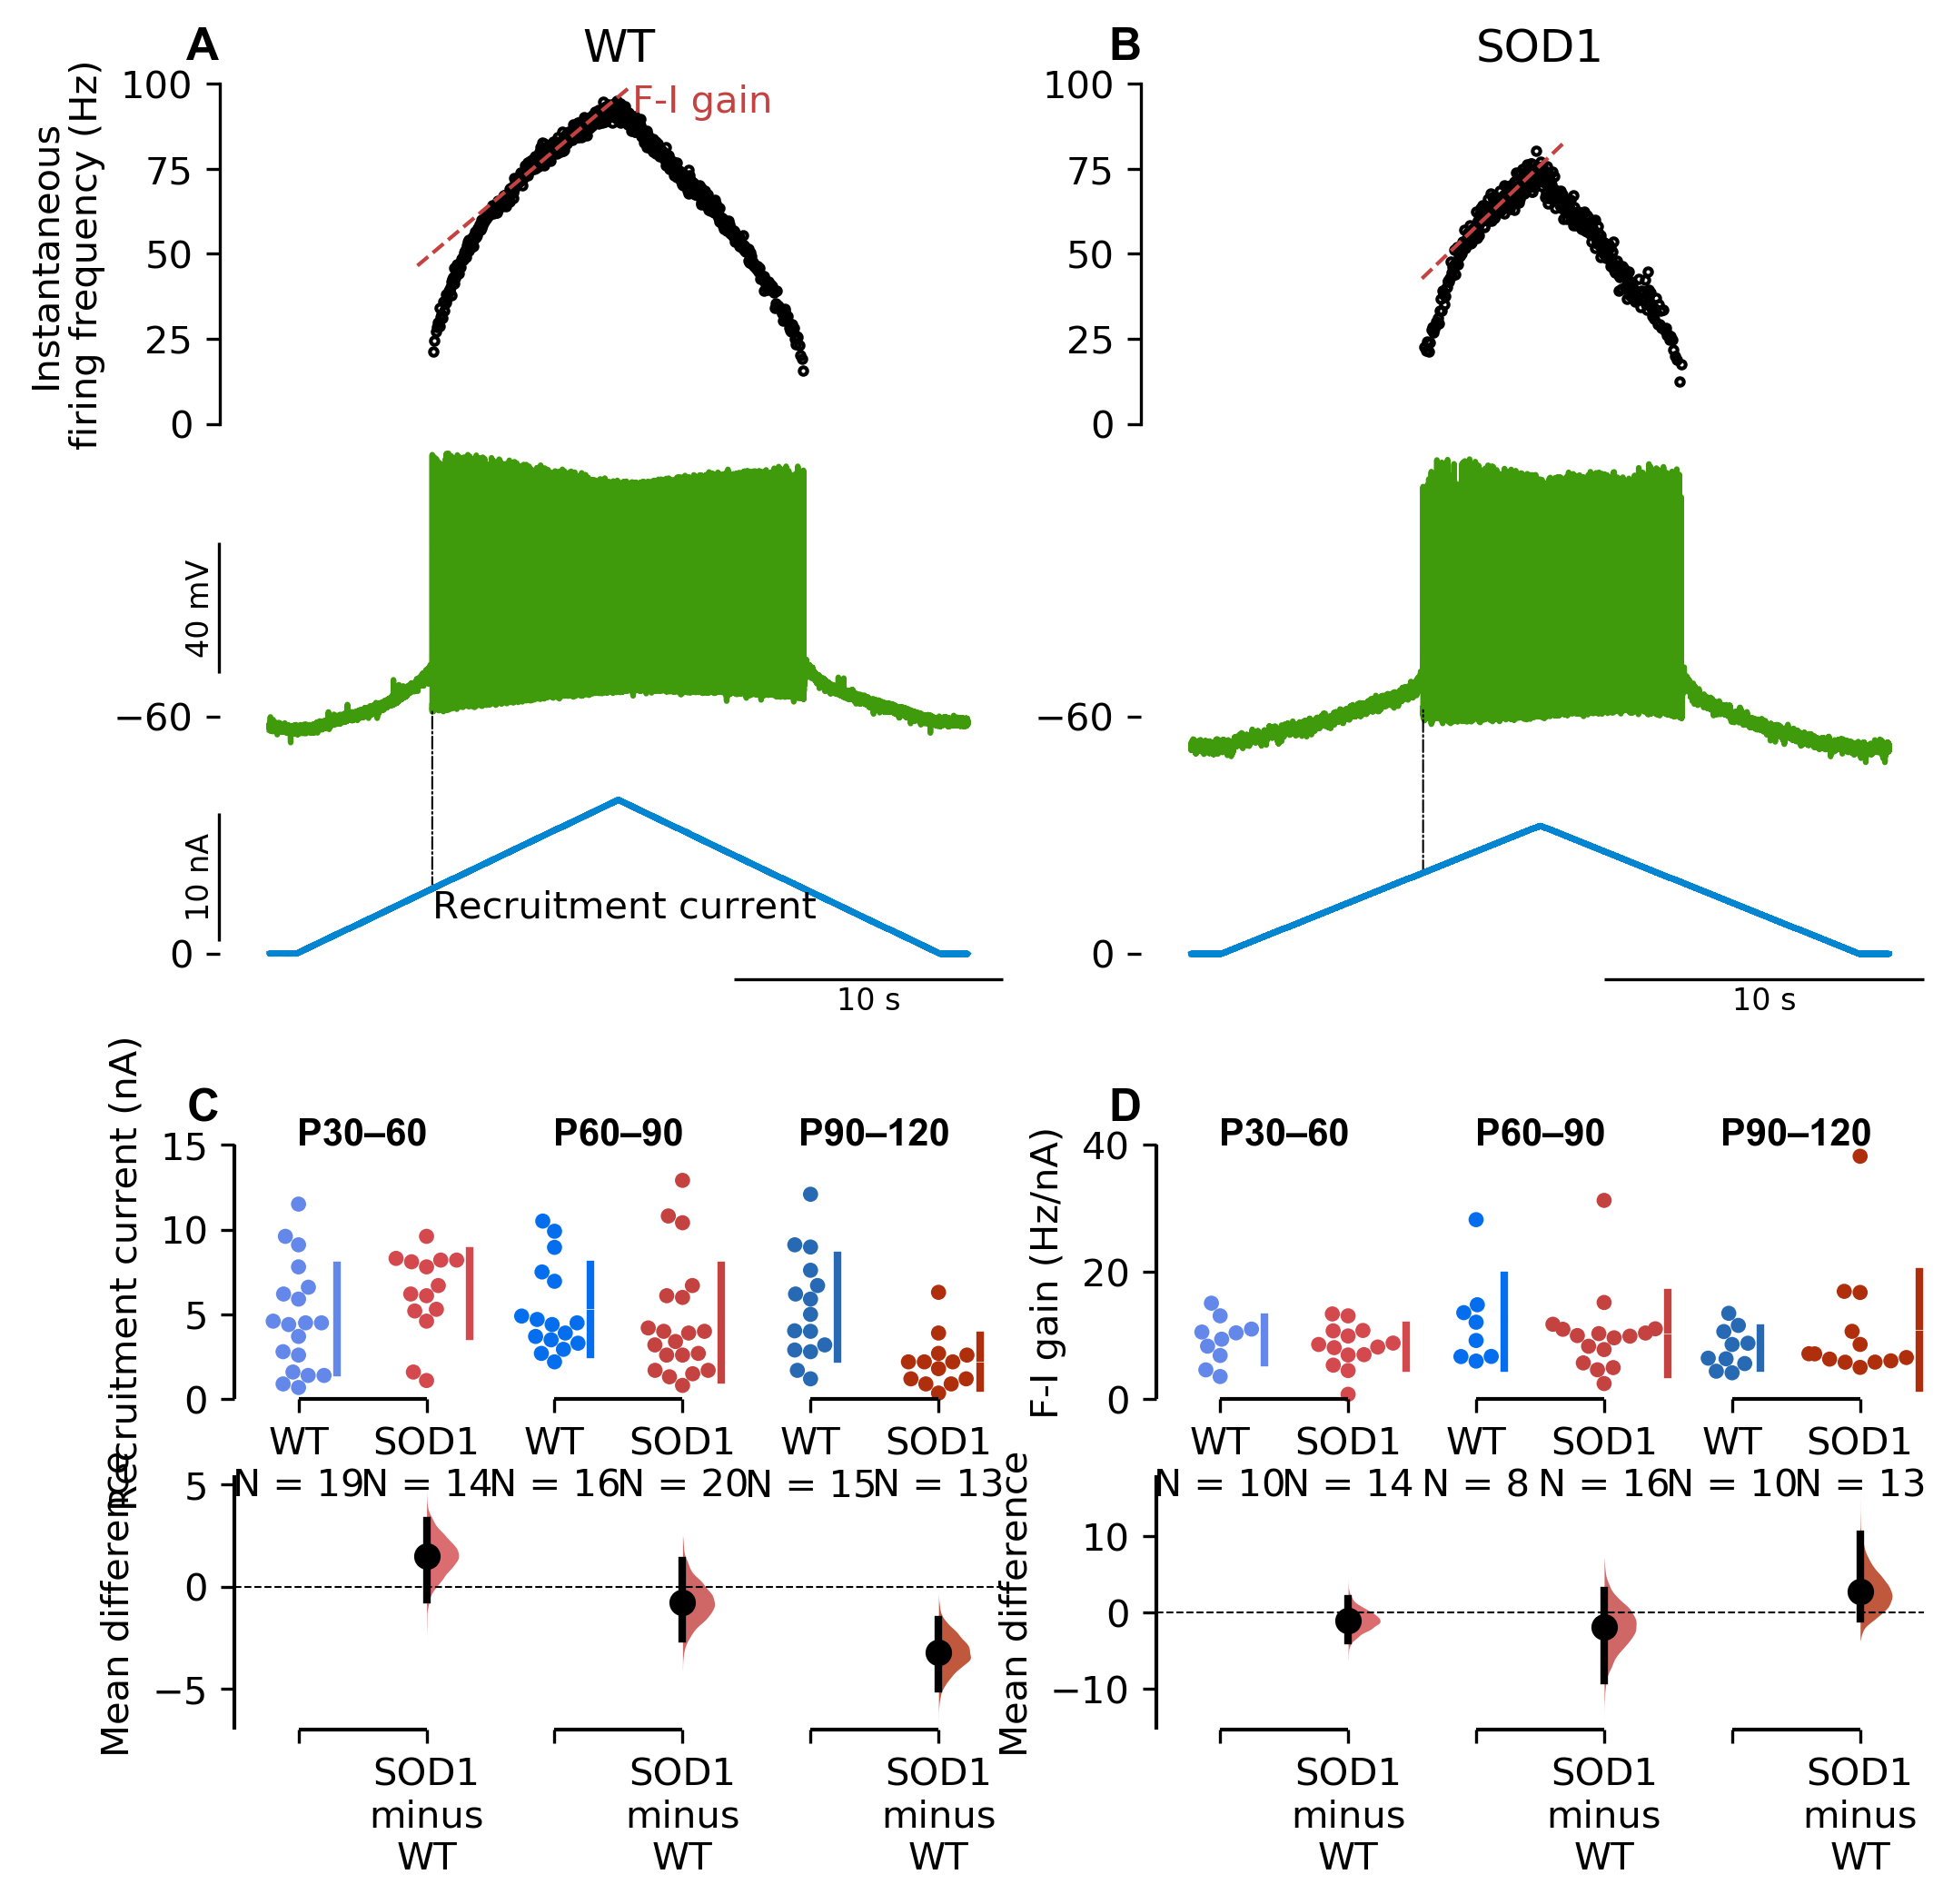

In [50]:
from matplotlib.patches import ConnectionPatch

fig = plt.figure(figsize=(8,8), dpi=300)

gs0 = gridspec.GridSpec(2,2,height_ratios=[3,2], figure=fig, hspace=0.25)
gs11 = gridspec.GridSpecFromSubplotSpec(3,2, subplot_spec=gs0[0,:],height_ratios=[2,2,1], hspace=0.05)

ax01 = fig.add_subplot(gs11[0,0])
ax01.plot(wtCCRamp['SpikeTimes'],wtCCRamp['SpikeFreq'],'o', ms=2, mec='k', mfc='none', clip_on=False)
ax01.plot(wtCCRamp['Time'],wtCCRamp['Gain'],'--', lw=1, c='xkcd:reddish')
ax01.annotate('F-I gain', xy=(99,100), ha='left',va='top',color='xkcd:reddish')
ax01.set_ylim(0,100)
sns.despine(ax=ax01, bottom=True, top=True, left=False, right=True, offset=4)
ax01.set_ylabel('Instantaneous\nfiring frequency (Hz)')

ax02 = fig.add_subplot(gs11[1,0], sharex=ax01)
ax02.plot(wtCCRamp['Time'],wtCCRamp['Vm'], c=Vm_color)
sns.despine(ax=ax02, bottom=True, top=True, left=False, right=True, offset=4)
ax02.spines['left'].set_visible(False)
ax02.set_yticks([-60])
ax02.set_xticks([])
vbar = VSizeBar(ax02.transData,
                40,
                "40 mV",
                loc='center right',
                pad=0, borderpad=0, sep=1,
                frameon=False,
                bbox_to_anchor=(-0.02, 0.5),
                bbox_transform=ax02.transAxes,textprops=dict(fontsize=8))
ax02.add_artist(vbar)


ax03 = fig.add_subplot(gs11[2,0], sharex=ax01)
ax03.plot(wtCCRamp['Time'],wtCCRamp['Im'], c=Im_color)
sns.despine(ax=ax03, bottom=True, top=True, left=False, right=True, offset=4)
ax03.spines['left'].set_visible(False)
ax03.set_yticks([0])
ax03.set_xticks([])
ibar = VSizeBar(ax03.transData,
                10,
                "10 nA",
                loc='center right',
                pad=0, borderpad=0, sep=1,
                frameon=False,
                bbox_to_anchor=(-0.02, 0.5),
                bbox_transform=ax03.transAxes,textprops=dict(fontsize=8))
ax03.add_artist(ibar)
tbar1 = HSizeBar(ax03.transData,
                 10,
                 '10 s',
                 loc='upper right',
                 pad=0, borderpad=0, sep=2,
                 frameon=False,
                 bbox_to_anchor=(1, -0.1),
                 bbox_transform=ax03.transAxes,textprops=dict(fontsize=8))
ax03.add_artist(tbar1)


xyB = (wtCCRamp.loc[0,'SpikeTimes'], -58)
xyA = (wtCCRamp.loc[0,'SpikeTimes'], 5)
con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data",
                  axesA=ax03, axesB=ax02, ls='-.', color='k', lw=0.5)
ax03.add_artist(con)
ax03.annotate('Recruitment current', xy=xyA, ha='left', va='top')

ax01.annotate('A', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')
ax01.set_title('WT')

ax11 = fig.add_subplot(gs11[0,1], sharey=ax01)
ax11.plot(sodCCRamp['SpikeTimes'],sodCCRamp['SpikeFreq'],'o', ms=2, mec='k', mfc='none', clip_on=False)
ax11.plot(sodCCRamp['Time'],sodCCRamp['Gain'],'--', lw=1, c='xkcd:reddish')
sns.despine(ax=ax11, bottom=True, top=True, left=False, right=True, offset=4)

ax12 = fig.add_subplot(gs11[1,1], sharey=ax02, sharex=ax11)
ax12.plot(sodCCRamp['Time'],sodCCRamp['Vm'], c=Vm_color)
sns.despine(ax=ax12, bottom=True, top=True, left=False, right=True, offset=4)
ax12.spines['left'].set_visible(False)
ax12.set_yticks([-60])
ax12.set_xticks([])


ax13 = fig.add_subplot(gs11[2,1], sharey=ax03, sharex=ax11)
ax13.plot(sodCCRamp['Time'],sodCCRamp['Im'], c=Im_color)
sns.despine(ax=ax13, bottom=True, top=True, left=False, right=True, offset=4)
ax13.spines['left'].set_visible(False)
ax13.set_yticks([0])
ax13.set_xticks([])
tbar1 = HSizeBar(ax13.transData,
                 10,
                 '10 s',
                 loc='upper right',
                 pad=0, borderpad=0, sep=2,
                 frameon=False,
                 bbox_to_anchor=(1, -0.1),
                 bbox_transform=ax13.transAxes,textprops=dict(fontsize=8))
ax13.add_artist(tbar1)

xyB = (sodCCRamp.loc[0,'SpikeTimes'], -58)
xyA = (sodCCRamp.loc[0,'SpikeTimes'], 6.3)
con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data",
                  axesA=ax13, axesB=ax12, ls='-.', color='k', lw=0.5)
ax13.add_artist(con)

ax11.annotate('B', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')
ax11.set_title('SOD1')

ax = ax3 = fig.add_subplot(gs0[1,0])
dabest_obj = mean_diffs['Ion']
swarm_label = 'Recruitment current (nA)'
contrast_label = None
ylim = (0,15) # for pretty ticks
panel_number = 'C'
dabest_obj.plot(ax=ax, 
                         swarm_label=swarm_label,
                         contrast_label=contrast_label,
                         custom_palette=my_palette,
                         raw_marker_size=4,
                         es_marker_size=6,
                         swarm_desat=1,
                         group_summaries='mean_sd',
                         reflines_kwargs=dict(linestyle='--', linewidth=0.5),
                         swarm_ylim=ylim,
                         swarmplot_kwargs={'clip_on':False}
                        );
ax.set_xticklabels([
    '\n'.join([
        label,tick.get_text().split('\n')[-1]]) for tick,label in zip(ax.get_xticklabels(), 
                                                                      itertools.cycle(genotypeOrder))])
for (i,label),(tickL,tickR) in zip(enumerate(ageOrder), grouper(ax.get_xticks(), 2)):
    ax.annotate(label, xy=(tickL+(tickR-tickL)/2,1), xycoords=('data','axes fraction'), 
                 fontfamily='Arial', ha='center', fontsize=10, fontweight='bold')
ax.contrast_axes.set_xticklabels(['\nminus\n'.join(genotypeOrder[::-1]) if i%2 else '' 
                                  for i,label in enumerate(ax.contrast_axes.get_xticklabels())])
ax.annotate(panel_number, xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')




ax = ax4 = fig.add_subplot(gs0[1,1])
dabest_obj = mean_diffs['Gain_Asc']
swarm_label = 'F-I gain (Hz/nA)'
contrast_label = None
ylim = (0,40) # for pretty ticks
panel_number = 'D'
dabest_obj.plot(ax=ax, 
                         swarm_label=swarm_label,
                         contrast_label=contrast_label,
                         custom_palette=my_palette,
                         raw_marker_size=4,
                         es_marker_size=6,
                         swarm_desat=1,
                         group_summaries='mean_sd',
                         reflines_kwargs=dict(linestyle='--', linewidth=0.5),
                         swarm_ylim=ylim,
                         swarmplot_kwargs={'clip_on':False}
                        );
ax.set_xticklabels([
    '\n'.join([
        label,tick.get_text().split('\n')[-1]]) for tick,label in zip(ax.get_xticklabels(), 
                                                                      itertools.cycle(genotypeOrder))])
for (i,label),(tickL,tickR) in zip(enumerate(ageOrder), grouper(ax.get_xticks(), 2)):
    ax.annotate(label, xy=(tickL+(tickR-tickL)/2,1), xycoords=('data','axes fraction'), 
                 fontfamily='Arial', ha='center', fontsize=10, fontweight='bold')
ax.contrast_axes.set_xticklabels(['\nminus\n'.join(genotypeOrder[::-1]) if i%2 else '' 
                                  for i,label in enumerate(ax.contrast_axes.get_xticklabels())])
ax.annotate(panel_number, xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')

# Figure 3

Text(-4, 4, 'B')

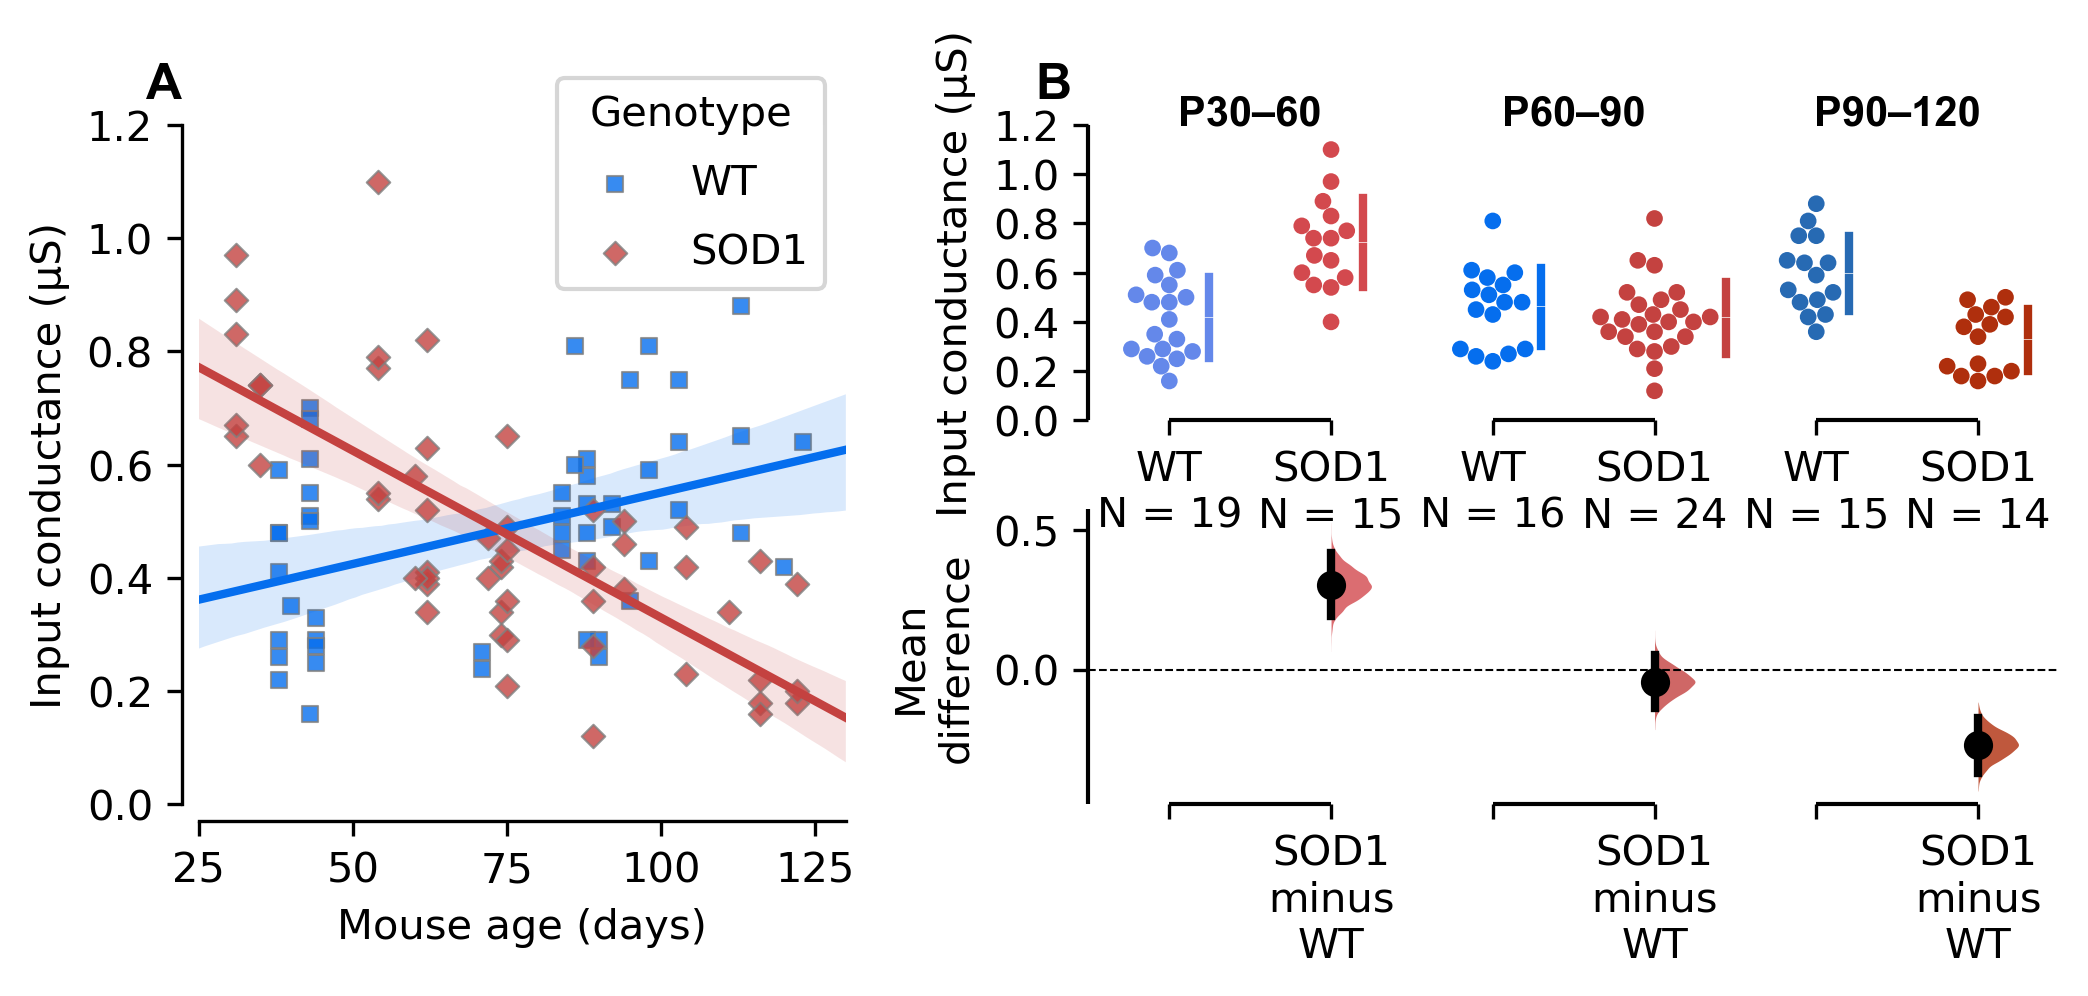

In [51]:

fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(8,3), 
                                           sharey='row', 
                                           gridspec_kw={'width_ratios':[2,3], 'wspace':0.3},
                                           dpi=300
                                          )

ax1.set_xlim(25,130)
for g,c,m in zip(genotypeOrder,[my_palette['WT_P60–90'], my_palette['SOD1_P60–90']],['s','D']):
    d = data[data['Genotype']==g]
    sns.regplot(data=d, x='MouseAge', y='Gin', ax=ax1, color=c, marker=m,
                scatter=True, scatter_kws=dict(s=4**2, edgecolor='gray', linewidth=0.5),
                fit_reg=True, label=g, line_kws={'lw':2}, truncate=False)
ax1.legend(title='Genotype', labelspacing=0.7, bbox_to_anchor=(1.,1.1))
sns.despine(ax=ax1, offset=4)
ax1.set_xlabel("Mouse age (days)")
ax1.set_ylabel('Input conductance (μS)')
ax1.set_ylim(0,1.2) # for pretty ticks
ax1.annotate('A', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')


mean_diffs['Gin'].plot(ax=ax2, 
                         swarm_label='Input conductance (μS)',
                         contrast_label='Mean\ndifference',
                         custom_palette=my_palette,
                         raw_marker_size=4,
                         es_marker_size=6,
                         swarm_desat=1,
                         group_summaries='mean_sd',
                         reflines_kwargs=dict(linestyle='--', linewidth=0.5)
                        );
ax2.set_xticklabels([
    '\n'.join([
        label,tick.get_text().split('\n')[-1]]) for tick,label in zip(ax2.get_xticklabels(), 
                                                                      itertools.cycle(genotypeOrder))])
for (i,label),(tickL,tickR) in zip(enumerate(ageOrder), grouper(ax2.get_xticks(), 2)):
    ax2.annotate(label, xy=(tickL+(tickR-tickL)/2,1), xycoords=('data','axes fraction'), 
                 fontfamily='Arial', ha='center', fontsize=10, fontweight='bold')
ax2.contrast_axes.set_xticklabels(['\nminus\n'.join(genotypeOrder[::-1]) if i%2 else '' for i,label in enumerate(ax2.contrast_axes.get_xticklabels())])
ax2.annotate('B', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')


# Figure 4

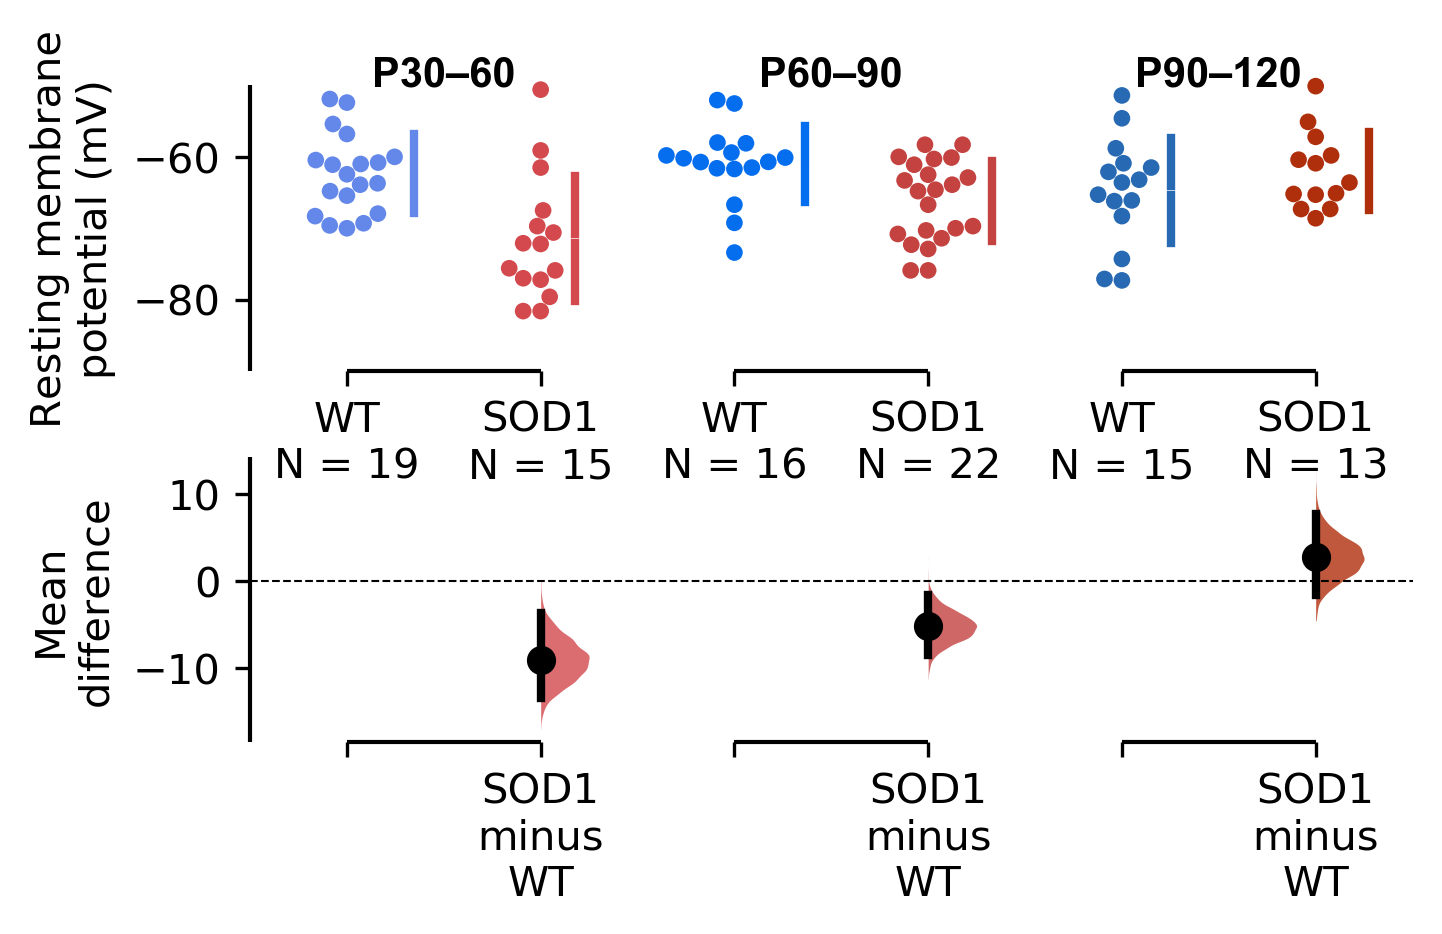

In [52]:
fig, ax2 = plt.subplots(1,1, figsize=(5,3), dpi=300)

fig.subplots_adjust(bottom=0.15)

mean_diffs['RMP'].plot(ax=ax2, 
                         swarm_label='Resting membrane\npotential (mV)',
                         contrast_label='Mean\ndifference',
                         custom_palette=my_palette,
                         raw_marker_size=4,
                         es_marker_size=6,
                         swarm_desat=1,
                         group_summaries='mean_sd',
                         reflines_kwargs=dict(linestyle='--', linewidth=0.5),
                   swarm_ylim=(-90,-50),
                   swarmplot_kwargs=dict(clip_on=False)
                        );

ax2.set_xticklabels([
    '\n'.join([
        label,tick.get_text().split('\n')[-1]]) for tick,label in zip(ax2.get_xticklabels(), 
                                                                      itertools.cycle(genotypeOrder))])
for (i,label),(tickL,tickR) in zip(enumerate(ageOrder), grouper(ax2.get_xticks(), 2)):
    ax2.annotate(label, xy=(tickL+(tickR-tickL)/2,1), xycoords=('data','axes fraction'), 
                 fontfamily='Arial', ha='center', fontsize=10, fontweight='bold')
ax2.contrast_axes.set_xticklabels(['\nminus\n'.join(genotypeOrder[::-1]) if i%2 else '' for i,label in enumerate(ax2.contrast_axes.get_xticklabels())])

plt.show()

# Figure 5

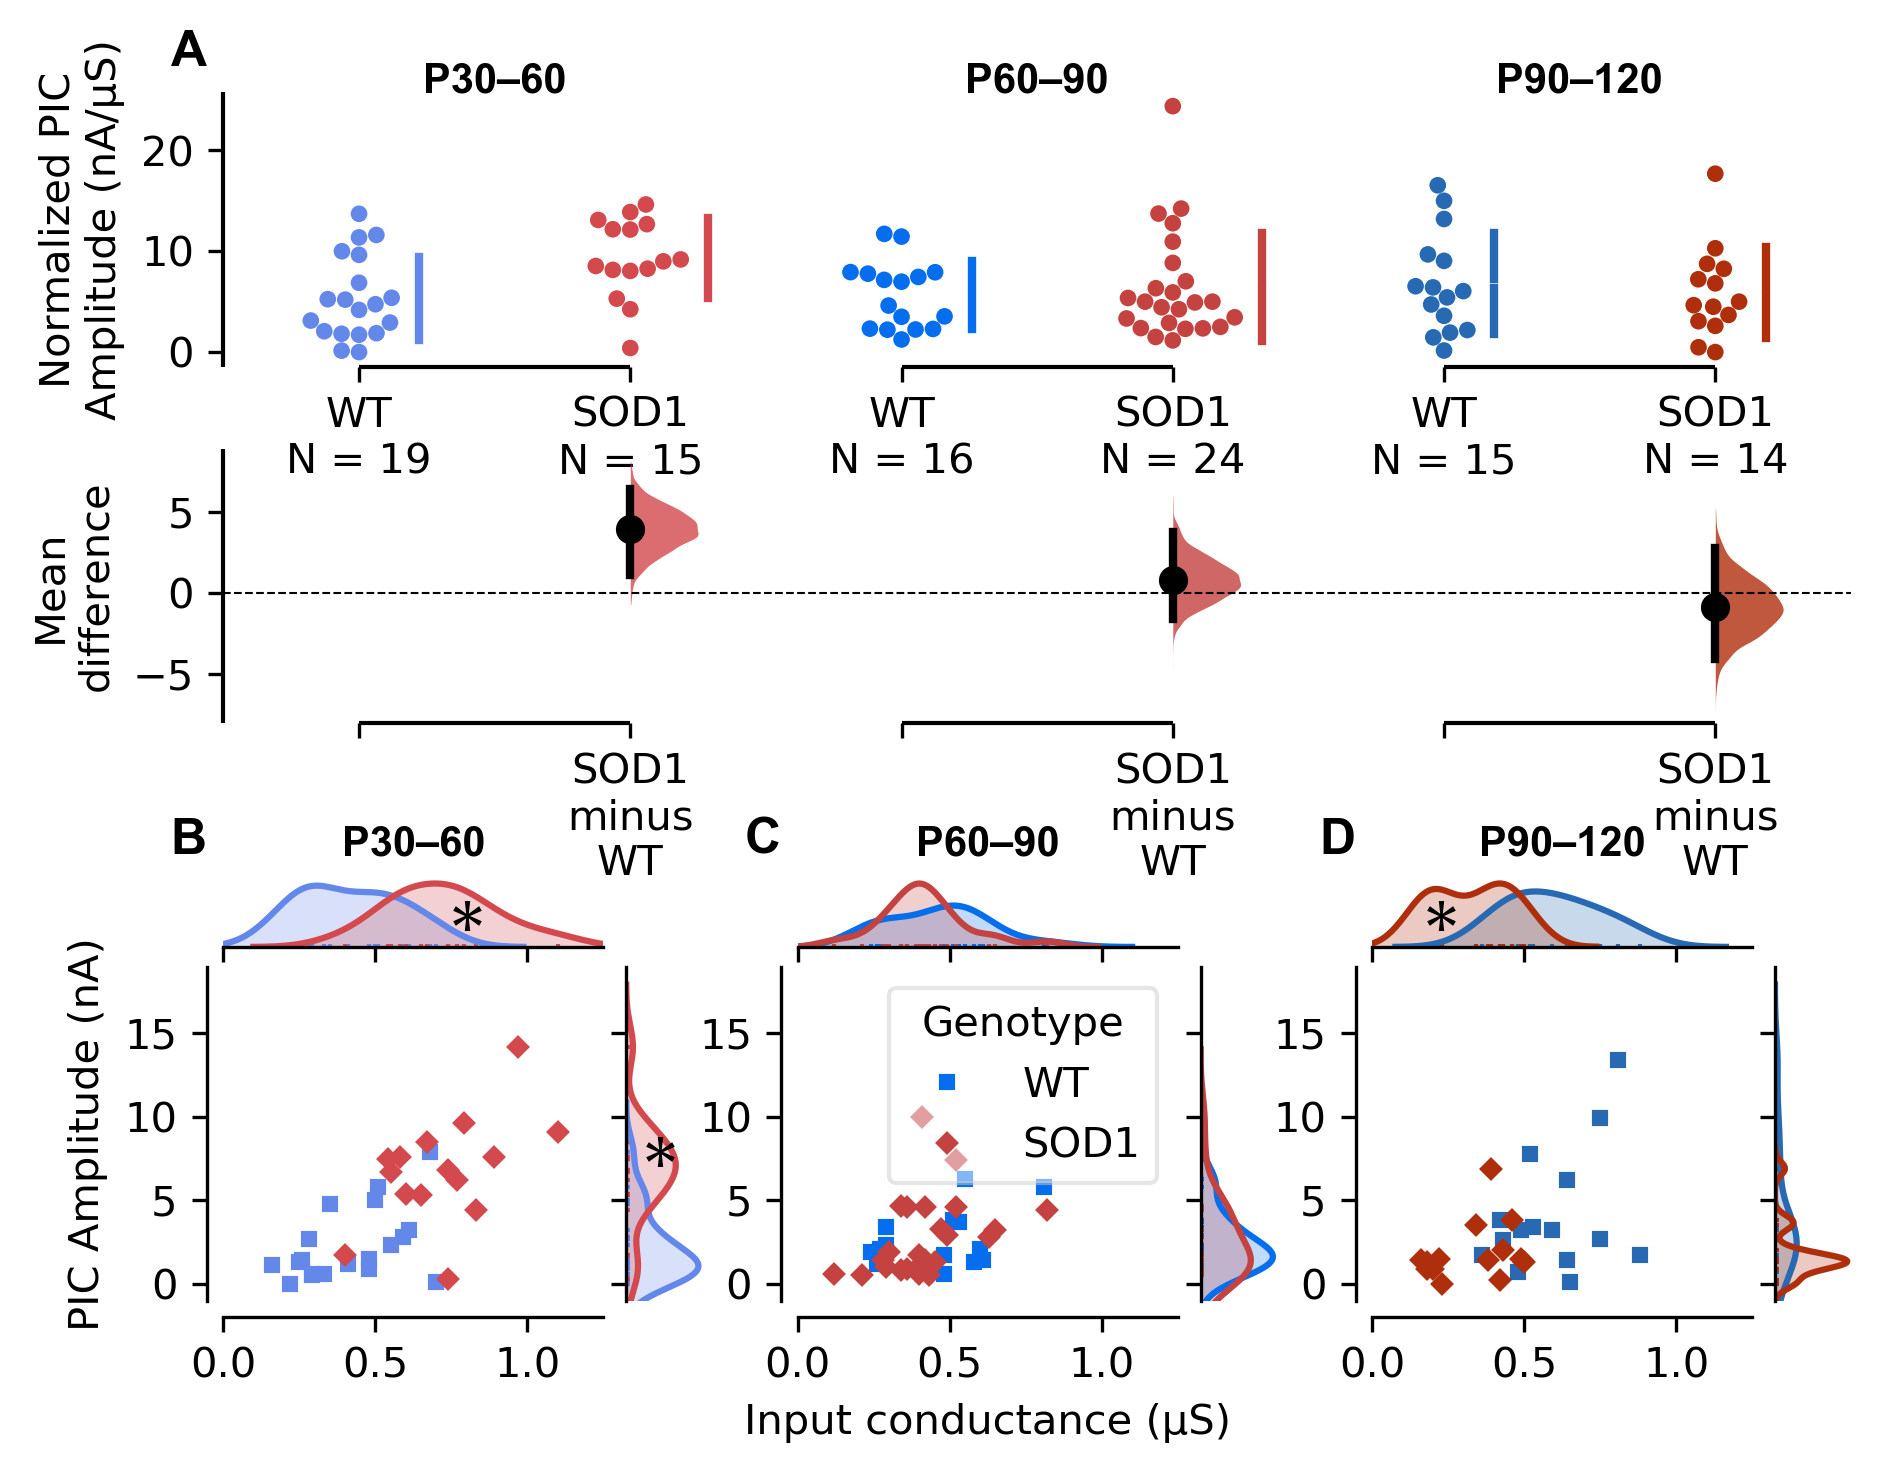

In [53]:

W = 2
sp=.1
fig = plt.figure(figsize=(W*(3+3/6),W*(1+1/6)+1.5*W), dpi=300)
gs1 = gridspec.GridSpec(2,3, figure=fig, height_ratios=[1.5,1], hspace=3*sp)
gs00 = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=gs1[1,0], height_ratios=[1,5], width_ratios=[5,1], wspace=sp, hspace=sp)
gs01 = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=gs1[1,1], height_ratios=[1,5], width_ratios=[5,1], wspace=sp, hspace=sp)
gs02 = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=gs1[1,2], height_ratios=[1,5], width_ratios=[5,1], wspace=sp, hspace=sp)


ax4 = fig.add_subplot(gs1[0,:])
fig = mean_diffs['PIC/Gin'].plot(ax=ax4, 
                         swarm_label='Normalized PIC\nAmplitude (nA/μS)', 
                         contrast_label='Mean\ndifference',
                         custom_palette=my_palette,
                         raw_marker_size=4,
                         es_marker_size=6,
                         swarm_desat=1,
                         group_summaries='mean_sd',
                         reflines_kwargs=dict(linestyle='--', linewidth=0.5), swarmplot_kwargs=dict(clip_on=False)
                        );
ax4.set_xticklabels([
    '\n'.join([
        label,tick.get_text().split('\n')[-1]]) for tick,label in zip(ax4.get_xticklabels(), 
                                                                      itertools.cycle(genotypeOrder))])
for (i,label),(tickL,tickR) in zip(enumerate(ageOrder), grouper(ax4.get_xticks(), 2)):
    ax4.annotate(label, xy=(tickL+(tickR-tickL)/2,1), xycoords=('data','axes fraction'), 
                 fontfamily='Arial', ha='center', fontsize=10, fontweight='bold')
ax4.contrast_axes.set_xticklabels(['\nminus\n'.join(genotypeOrder[::-1]) if i%2 else '' for i,label in enumerate(ax4.contrast_axes.get_xticklabels())])
ax4.annotate('A', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')




young_main = fig.add_subplot(gs00[1,0])
young_top = fig.add_subplot(gs00[0,0], sharex=young_main)
young_bottom = fig.add_subplot(gs00[1,1], sharey=young_main)

med_main = fig.add_subplot(gs01[1,0], sharex=young_main, sharey=young_main)
med_top = fig.add_subplot(gs01[0,0], sharex=med_main)
med_bottom = fig.add_subplot(gs01[1,1], sharey=med_main)

old_main = fig.add_subplot(gs02[1,0], sharex=young_main, sharey=young_main)
old_top = fig.add_subplot(gs02[0,0], sharex=old_main)
old_bottom = fig.add_subplot(gs02[1,1], sharey=old_main)

color_iter = iter(my_palette.values())
markers = ['s','D']
for (g,temp),(main,top,bottom),label in zip(data.groupby('AgeGroup'),
                                            ((young_main,young_top,young_bottom),
                                             (med_main, med_top, med_bottom),
                                             (old_main, old_top, old_bottom)),
                                            ('B','C','D')):

    for G,m in zip(genotypeOrder,markers):
        sub = temp.loc[temp['Genotype']==G]
        c = next(color_iter)
        main.plot(sub['Gin'], sub['PIC Amp'], color=c, marker=m, lw=0, label=G, ms=3)

        sns.distplot(sub['Gin'], ax=top, rug=True, hist=False, kde_kws=dict(shade=True), color=c)
        sns.distplot(sub['PIC Amp'], ax=bottom, rug=True, hist=False, kde_kws=dict(shade=True), vertical=True, color=c)

    top.set_title(g, fontfamily='Arial', ha='center', fontsize=10, fontweight='bold')
    sns.despine(ax=main, offset=4)
    main.set_xlabel('')
    main.set_xlim(0,1.25)
    main.set_ylim(bottom=-1) # too much whitespace
    top.annotate(label, xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')



    sns.despine(ax=top, offset=0, left=True)
    top.spines['left'].set_position(('outward', 4))
    sns.despine(ax=bottom, offset=0, bottom=True)
    bottom.spines['bottom'].set_position(('outward', 4))
    top.set_xlabel('')
    bottom.set_ylabel('')
    plt.setp(top.get_xticklabels(), visible=False)
    plt.setp(bottom.get_yticklabels(), visible=False)
    top.set_yticks([])
    bottom.set_xticks([])

young_main.set_ylabel('PIC Amplitude (nA)')
med_main.set_xlabel('Input conductance (μS)')
med_main.legend(title='Genotype', loc='upper right', framealpha=0.5)

young_top.annotate('✱', xy=(0.75,0.25), xycoords=('data','axes fraction'), fontfamily='Arial Unicode MS')
young_bottom.annotate('✱', xy=(0.25,7), xycoords=('axes fraction','data'), fontfamily='Arial Unicode MS')
old_top.annotate('✱', xy=(0.175,0.25), xycoords=('data','axes fraction'), fontfamily='Arial Unicode MS')

plt.show()

# Figure 6

In [54]:
noFGin = dabest.load(data=data.loc[data['Genotype']=='SOD1'], idx=('Firing', 'Non-firing'), x='RepFiring', y='Gin')
noFPICAmp = dabest.load(data=data.loc[data['Genotype']=='SOD1'], idx=('Firing', 'Non-firing'), x='RepFiring', y='PIC Amp')
noFPICNormPICAmp = dabest.load(data=data.loc[data['Genotype']=='SOD1'], idx=('Firing', 'Non-firing'), x='RepFiring', y='PIC/Gin')
noFAge = dabest.load(data=data.loc[data['RepFiring']=='Non-firing'], idx=('WT', 'SOD1'), x='Genotype', y='MouseAge')

In [55]:
noFexample = pd.read_csv('./Cell692_004-005_exampleNoF.txt')

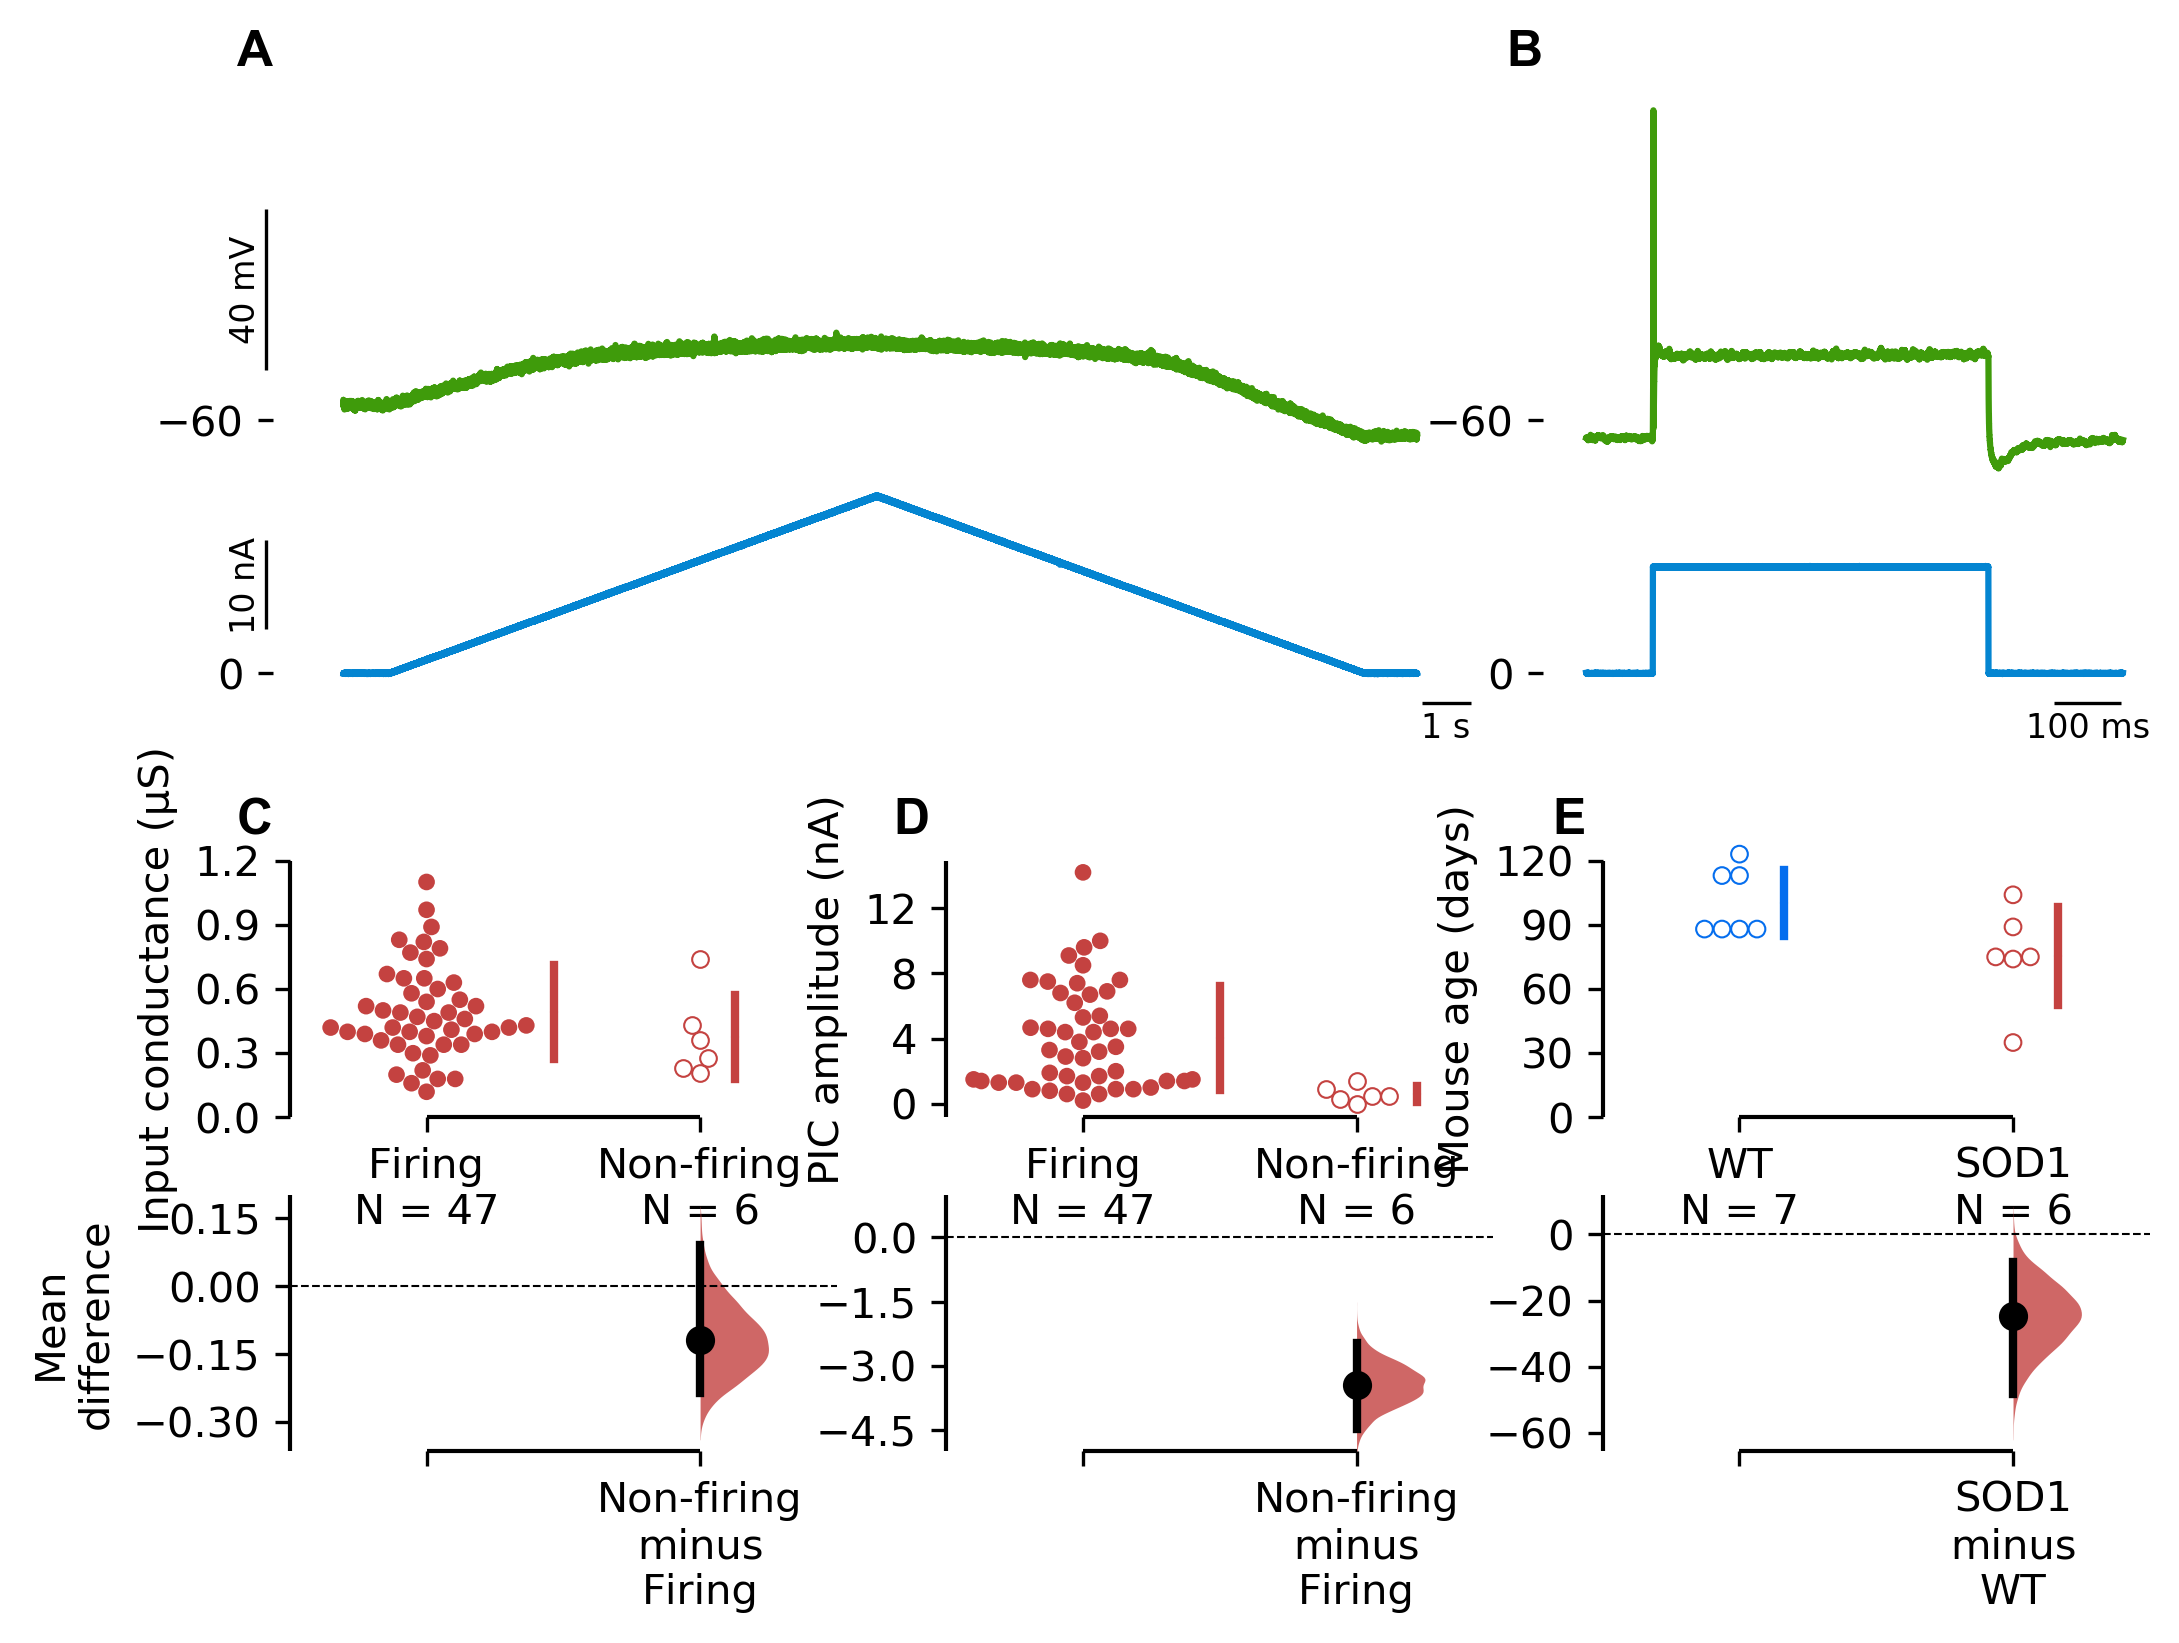

In [56]:
palette_noF = {'Firing': 'xkcd:reddish',
               'Non-firing': 'xkcd:reddish'}
palette_age = {'WT':'xkcd:cerulean blue','SOD1':'xkcd:reddish'}


fig = plt.figure(figsize=(8,6), dpi=300)
gs0 = gridspec.GridSpec(2,3, figure=fig, height_ratios=[1,1], hspace=0.3)

gs00 = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=gs0[0,:], width_ratios=[2,1], height_ratios=[2,1], hspace=0, wspace=0.1)
ax00 = fig.add_subplot(gs00[0,0])
ax10 = fig.add_subplot(gs00[0,1], sharey=ax00)
ax01 = fig.add_subplot(gs00[1,0])
ax11 = fig.add_subplot(gs00[1,1], sharey=ax01)

ax00.plot(noFexample['CCRampTime'], noFexample['CCRampVm'], '-', c=Vm_color)
ax01.plot(noFexample['CCRampTime'], noFexample['CCRampIm'], '-', c=Im_color)

ax10.plot(noFexample['PulseTime'], noFexample['PulseVm'], '-', c=Vm_color)
ax11.plot(noFexample['PulseTime'], noFexample['PulseIm'], '-', c=Im_color)

for ax in [ax00,ax01,ax10,ax11]:
    sns.despine(ax=ax, bottom=True, left=False, right=True, top=True, offset=4)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
ax00.set_yticks([-60])
#ax10.set_yticks([-60])
ax01.set_yticks([0])
#ax11.set_yticks([0])
ax00.annotate('A', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')
ax10.annotate('B', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')
vbar = VSizeBar(ax00.transData,
                40,
                "40 mV",
                loc='center right',
                pad=0, borderpad=0, sep=1,
                frameon=False,
                bbox_to_anchor=(-0.02, 0.5),
                bbox_transform=ax00.transAxes,textprops=dict(fontsize=8))
ax00.add_artist(vbar)
ibar = VSizeBar(ax01.transData,
                10,
                "10 nA",
                loc='center right',
                pad=0, borderpad=0, sep=1,
                frameon=False,
                bbox_to_anchor=(-0.02, 0.5),
                bbox_transform=ax01.transAxes,textprops=dict(fontsize=8))
ax01.add_artist(ibar)
tbar1 = HSizeBar(ax01.transData,
                 1,
                 '1 s',
                 loc='upper right',
                 pad=0, borderpad=0, sep=2,
                 frameon=False,
                 bbox_to_anchor=(1, -0.1),
                 bbox_transform=ax01.transAxes,textprops=dict(fontsize=8))
ax01.add_artist(tbar1)
tbar2 = HSizeBar(ax11.transData,
                 0.1,
                 '100 ms',
                 loc='upper right',
                 pad=0, borderpad=0, sep=2,
                 frameon=False,
                 bbox_to_anchor=(1, -0.1),
                 bbox_transform=ax11.transAxes,textprops=dict(fontsize=8))
ax11.add_artist(tbar2)


ax1 = fig.add_subplot(gs0[1,0])
ax2 = fig.add_subplot(gs0[1,1])
ax3 = fig.add_subplot(gs0[1,2])

noFGin.mean_diff.plot(ax=ax1, float_contrast=False,
                     swarm_label='Input conductance (μS)', 
                     contrast_label='Mean\ndifference',
                     custom_palette=palette_noF,
                     raw_marker_size=4,
                     es_marker_size=6,
                     swarm_desat=1,
                     group_summaries='mean_sd',
                     reflines_kwargs=dict(linestyle='--', linewidth=0.5), swarmplot_kwargs=dict(clip_on=False),
                     swarm_ylim=(0,1.2)); # for pretty ticks
ax1.collections[1].set_facecolor('w')
ax1.collections[1].set_edgecolor('xkcd:reddish')
ax1.collections[1].set_linewidth(0.5)
noFPICAmp.mean_diff.plot(ax=ax2, float_contrast=False,
                     swarm_label='PIC amplitude (nA)', 
                     contrast_label='',
                     custom_palette=palette_noF,
                     raw_marker_size=4,
                     es_marker_size=6,
                     swarm_desat=1,
                     group_summaries='mean_sd',
                     reflines_kwargs=dict(linestyle='--', linewidth=0.5), swarmplot_kwargs=dict(clip_on=False),
                     contrast_ylim=(-5,1)); # otherwise zero-line not visible
ax2.collections[1].set_facecolor('w')
ax2.collections[1].set_edgecolor('xkcd:reddish')
ax2.collections[1].set_linewidth(0.5)
noFAge.mean_diff.plot(ax=ax3, float_contrast=False,
                     swarm_label='Mouse age (days)', 
                     contrast_label='',
                     custom_palette=palette_age,
                     raw_marker_size=4,
                     es_marker_size=6,
                     swarm_desat=1,
                     group_summaries='mean_sd',
                     reflines_kwargs=dict(linestyle='--', linewidth=0.5), swarmplot_kwargs=dict(clip_on=False),
                     swarm_ylim=(0,120));

for col in ax3.collections[:2]:
    color = col.get_facecolor();
    col.set_facecolor('w')
    col.set_edgecolor(color)
    col.set_linewidth(0.5)

for ax,l in zip([ax1,ax2,ax3],['C','D','E']):
    ax.annotate(l, xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.contrast_axes.yaxis.set_major_locator(ticker.MaxNLocator(4))


# Figure 7

In [57]:
params = ['Gin', 'PIC Amp', 'V_PIC onset', 'RMP']
timePoints = ['P0–5','P6–12','P30–60','P60–90','P90–120']
x_vals = [2.5, 9, 45, 75, 105]

create a dataframe with the values of hedges' *g* and 95%CI for each time point and each parameter

In [58]:
evol_df = pd.DataFrame(columns=pd.MultiIndex.from_product([timePoints,['g','ci']]), index=params)
# populate with the data from this study
for prop in params:
    temp = pd.DataFrame(columns=['g','ci'], index=['P30–60','P60–90','P90–120'])
    temp['g'] = hedges_gs[prop].statistical_tests['difference'].tolist()
    temp['ci'] = hedges_gs[prop].statistical_tests[['difference','bca_high']].diff(axis=1).iloc[:,-1].tolist()
    evol_df.loc[prop] = temp.stack()

P0–5 and P6–12 data are from Quinlan, K. A.; Schuster, J. E.; Fu, R.; Siddique, T.; Heckman, C. J. Altered Postnatal Maturation of Electrical Properties in Spinal Motoneurons in a Mouse Model of Amyotrophic Lateral Sclerosis. The Journal of Physiology 2011, 589 (Pt 9), 2245–2260.

In [59]:
data_Quinlan_txt = """
P0–5	P0–5	P6–12	P6–12
g	ci	g	ci
Gin	0.47283915573858193	0.5539094040548855	0.4843948929275647	0.49918247003312594
PIC Amp	1.0718056524203396	0.7531457347705782	0.8434878612474501	0.6349896646307589
V_PIC onset	0.0	0.7026213441015631	-0.32471256673663484	0.6116454401905217
RMP	0.24427480916030533	0.7026213441015631	0.0	0.6116454401905217
"""
temp = pd.read_csv(StringIO(data_Quinlan_txt), sep='\t', header=[0,1])
evol_df['P0–5'] = temp['P0–5']
evol_df['P6–12'] = temp['P6–12']

In [60]:
evol_df

P0–5               P6–12             P30–60            \
                    g        ci         g        ci        g        ci   
Gin          0.472839  0.553909  0.484395  0.499182  1.72922  0.666413   
PIC Amp      1.071806  0.753146  0.843488  0.634990  1.59266  0.882355   
V_PIC onset  0.000000  0.702621 -0.324713  0.611645  -1.8278    1.0163   
RMP          0.244275  0.702621  0.000000  0.611645 -1.24136  0.958021   

                P60–90             P90–120            
                     g        ci         g        ci  
Gin          -0.283289   0.67212  -1.85073  0.683687  
PIC Amp       0.124986  0.543573 -0.735718  0.736129  
V_PIC onset -0.0727106  0.609805   0.43386  0.733747  
RMP          -0.922005  0.736688  0.401405  0.698627

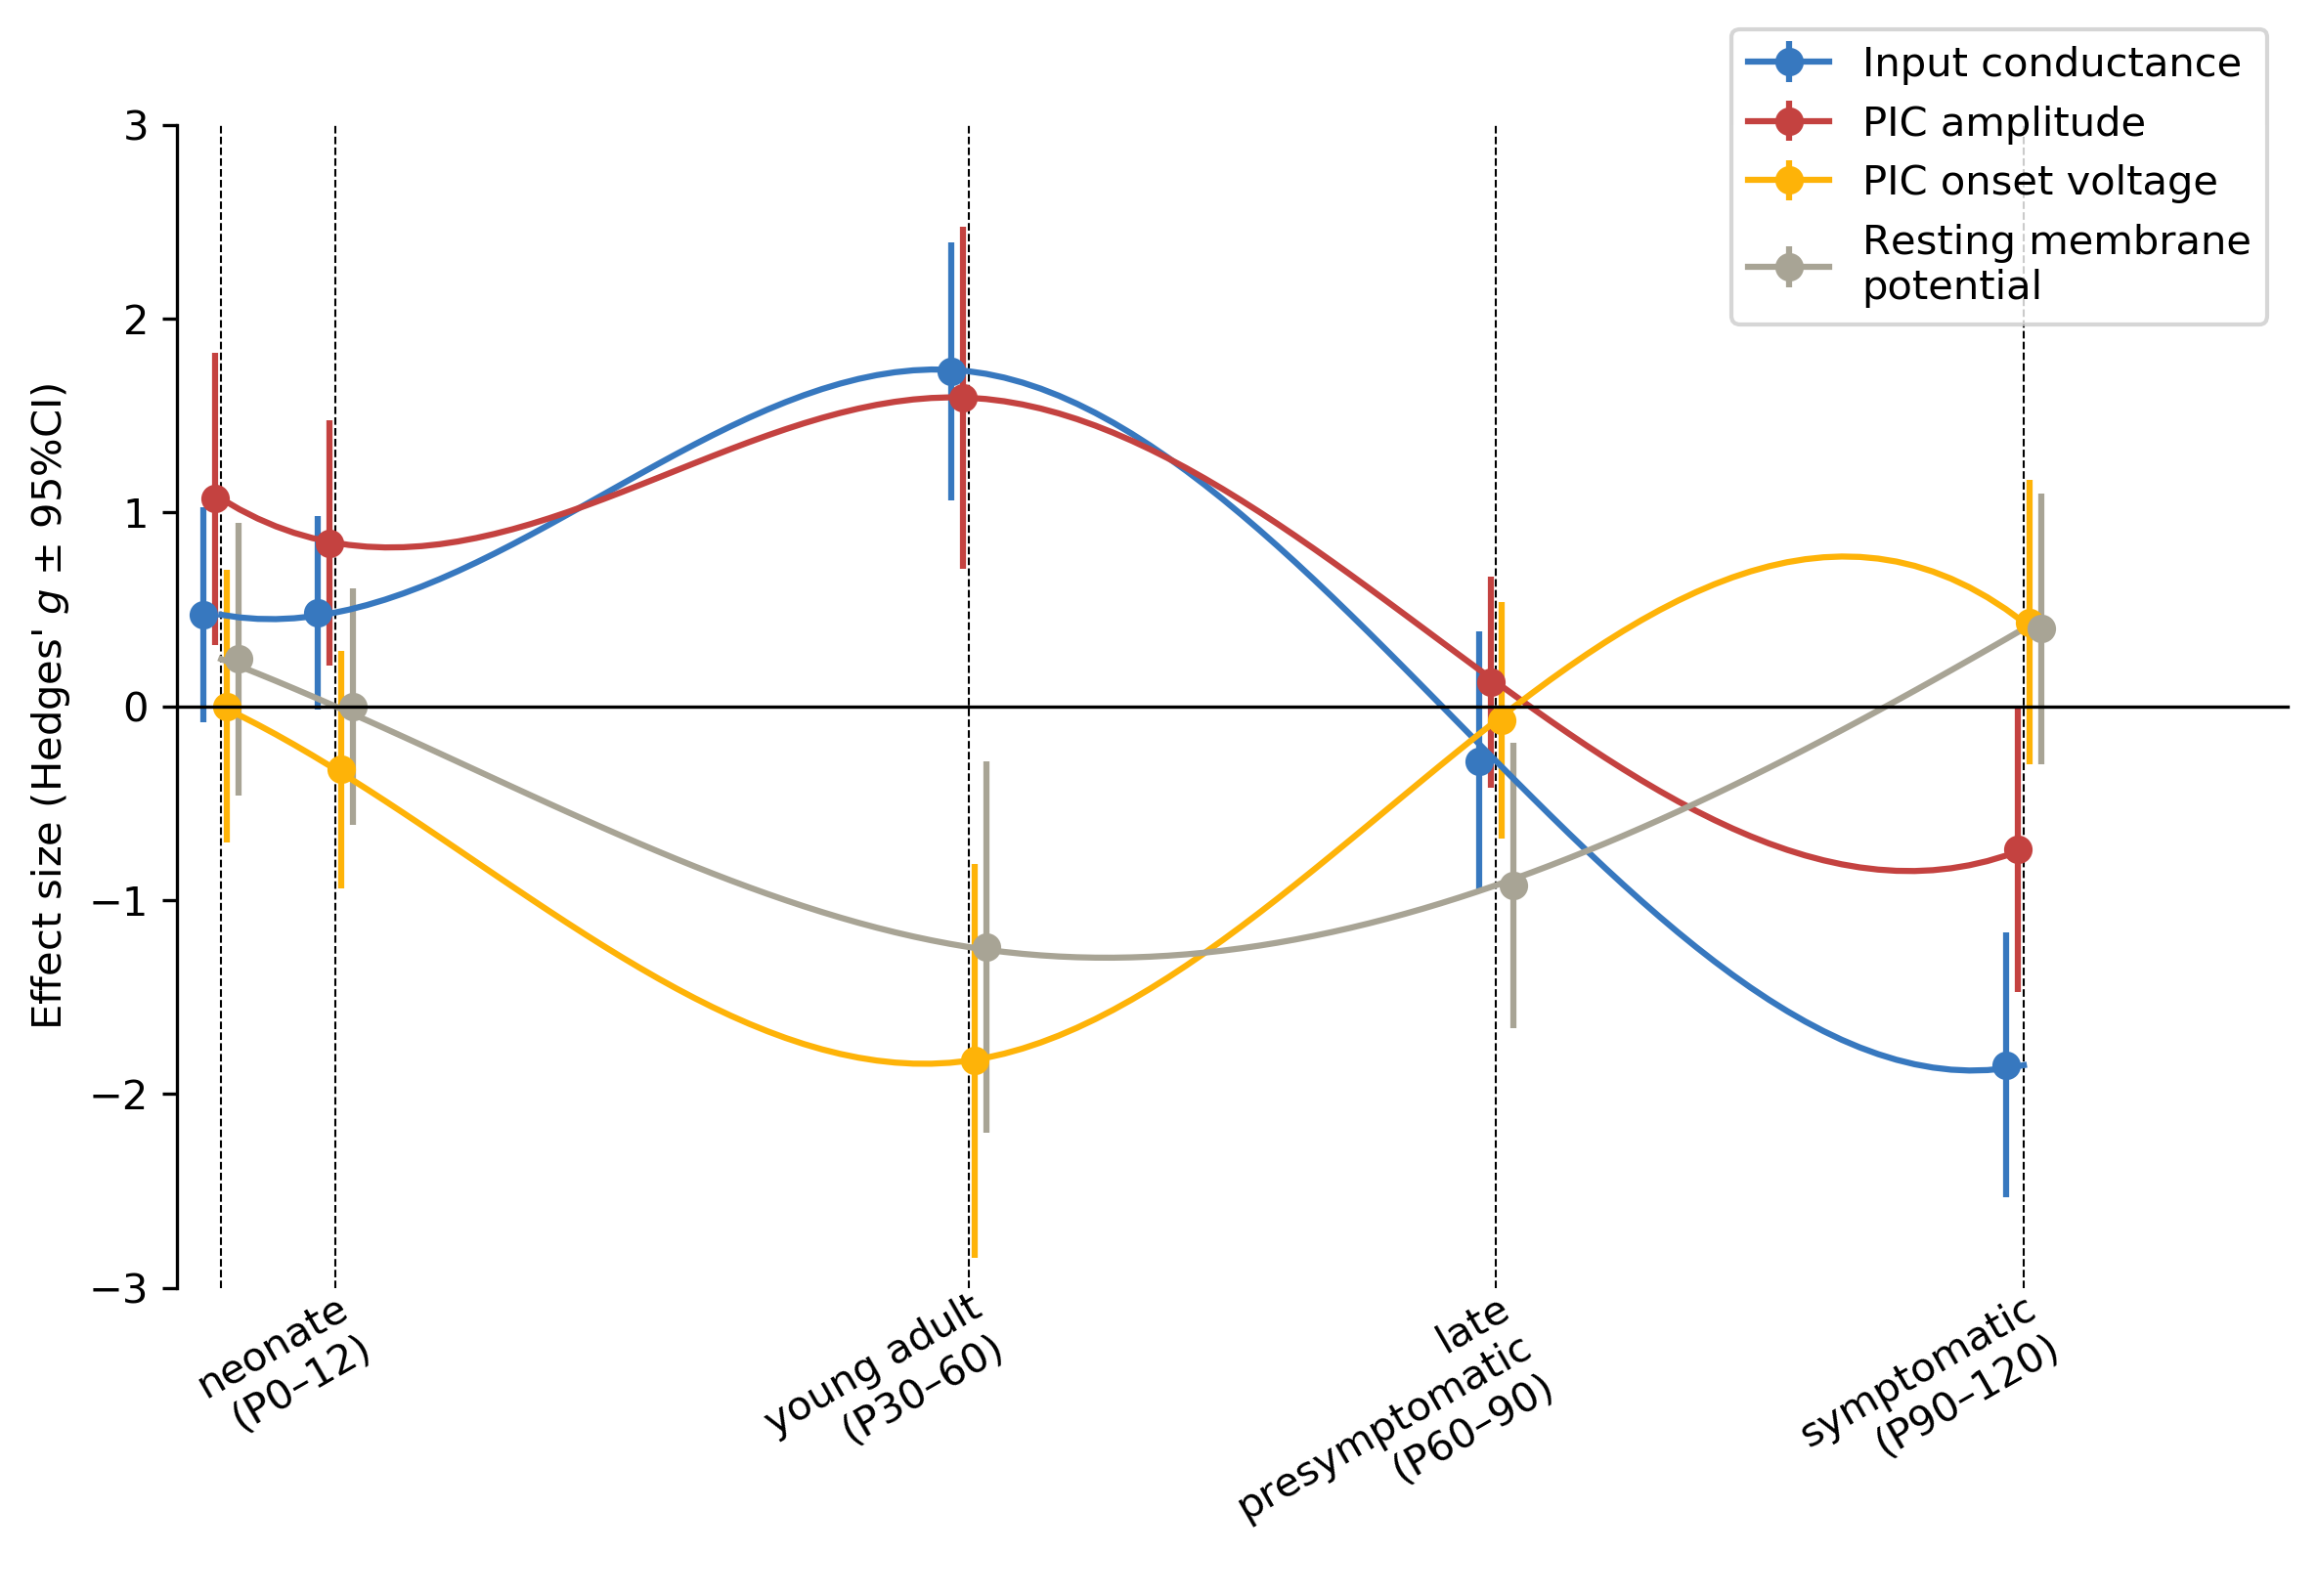

In [72]:
from scipy import interpolate
xnew = np.linspace(x_vals[0],x_vals[-1],100)

fig,ax = plt.subplots(figsize=(8,6), dpi=300)
cycler = itertools.cycle(plt.rcParams['axes.prop_cycle']) # color iterator
idx = pd.IndexSlice

#x_temp is used to jitter a bit the values on the x axis so that the CI do not overlap
for p,x_temp in zip(params, np.linspace(-1,1,len(params))): 
    c = next(cycler)['color']
    x_temp = x_vals + x_temp
    y = evol_df.loc[p,idx[:,'g']].values
    #ax.plot(x_temp, evol_df.loc[p,idx[:,'g']].values, 'o', color=c, label=p, clip_on=False)
    ax.errorbar(x_temp, y, yerr=evol_df.loc[p,idx[:,'ci']].values, fmt='o', color=c, clip_on=False, lw=1.5, label=p)
    tck = interpolate.splrep(x_vals, y, s=0)
    ynew = interpolate.splev(xnew, tck, der=0)
    ax.plot(xnew, ynew, '-', color=c, label=p, clip_on=False)

# this is a trick to combine the points+line in the legend
h,l = ax.get_legend_handles_labels()
h = [(h[i],h[i+len(params)]) for i in range(len(params))]
ax.legend(h,[props_labels[k] for k in params], loc='upper right', bbox_to_anchor=(1,1.1))

# other prettyfications
ax.set_ylabel('Effect size (Hedges\' $g$ ± 95%CI)')
ax.set_xlim(0,120)
ax.set_xticks([])
ax.set_ylim(-3,3)
ax.spines['bottom'].set_position('zero')
sns.despine(ax=ax)
#
for x,label in zip(x_vals, ['', 'neonate\n(P0–12)',
                                'young adult\n(P30–60)',
                                'late\npresymptomatic\n(P60–90)',
                                'symptomatic\n(P90–120)']):
    ax.axvline(x, ls='--', color='k', lw=0.5, zorder=0)
    ax.annotate(label, xy=(x,0), xycoords=('data','axes fraction'), xytext=(0,0), textcoords='offset points', rotation=30, ha="right", va='top', rotation_mode="anchor")

fig.tight_layout()
fig.subplots_adjust(bottom=0.25)